In [56]:
# General Utilities
import os
import random
import warnings
from pathlib import Path

# Numerical and Data Processing
import numpy as np
import pandas as pd
from scipy import stats

# Network Analysis
from community import community_louvain
from networkx.algorithms.community import greedy_modularity_communities
from select import error
from sklearn.metrics import normalized_mutual_info_score
import networkx_temporal as tx
import networkx as nx
import leidenalg as la
from mpl_toolkits.axes_grid1 import make_axes_locatable

# Visualization
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import seaborn as sns
from matplotlib.lines import Line2D
from matplotlib.offsetbox import OffsetImage, AnnotationBbox
from matplotlib.legend_handler import HandlerBase
from matplotlib.image import BboxImage
from matplotlib.transforms import Bbox, TransformedBbox
import matplotlib.lines as mlines

# Geospatial Data
import geopandas as gpd

# Country Information
import pycountry

# String Matching
from fuzzywuzzy import process

# Custom Modules
from dataloader import DataLoader

# Set global visualization and warning options
warnings.filterwarnings("ignore")

### 1) Load and Preprocess Data

In [57]:
# Load and preprocess dataset
hs_code = 282520
hs_label = "Lithium"

# hs_code = 280130
# hs_label = "Fluorine"

# Create dir for exporting plots
export_path = os.path.join("graphics", hs_label, hs_label)
Path(export_path).mkdir(parents=True, exist_ok=True)

# Load and preprocess dataset
loader = DataLoader(hs_code=hs_code)

_initialize_data took 40.5707 seconds


In [58]:
# Returns efficiently handled polar dataframe
polar_df = loader.get_data()

# Converts Polar dataframe to pandas for easier handling
df = polar_df.to_pandas()

# Extracts the distinct years
years = sorted(df['t'].unique())

## ADD DEGREE DIST

# Loads Base Data
baseline_df = loader.get_baseline(load_precompute=True)
yearly_baseline_graph = loader.get_yearly_baseline_graphs(baseline_df, years)

# Index structure for simplified access
yearly_graphs = loader.get_yearly_graphs(years)

df

t    i    j       k         v       q export_country  \
0      2002   36  124  282520     7.627   2.211      Australia   
1      2002   36  360  282520    15.395   1.120      Australia   
2      2002   36  372  282520     1.874   0.008      Australia   
3      2002   36  380  282520     2.748   0.003      Australia   
4      2002   36  554  282520     5.832   1.422      Australia   
...     ...  ...  ...     ...       ...     ...            ...   
10856  2022  842  757  282520    94.439   1.124            USA   
10857  2022  842  764  282520  6188.819  89.237            USA   
10858  2022  842  784  282520  2476.180  87.011            USA   
10859  2022  842  792  282520     0.873   0.045            USA   
10860  2022  842  826  282520  3502.654  72.402            USA   

             import_country                  description iso3_o  ... eu_o  \
0                    Canada  Lithium oxide and hydroxide    AUS  ...  0.0   
1                 Indonesia  Lithium oxide and hydroxide    AUS  ...  0.0   
2                   Ireland  Lithium oxide and hydroxide    AUS  ...  0.0   
3                     Italy  Lithium oxide and hydroxide    AUS  ...  0.0   
4               New Zealand  Lithium oxide and hydroxide    AUS  ...  0.0   
...                     ...                          ...    ...  ...  ...   
10856           Switzerland  Lithium oxide and hydroxide   None  ...  NaN   
10857              Thailand  Lithium oxide and hydroxide   None  ...  NaN   
10858  United Arab Emirates  Lithium oxide and hydroxide   None  ...  NaN   
10859               Türkiye  Lithium oxide and hydroxide   None  ...  NaN   
10860        United Kingdom  Lithium oxide and hydroxide   None  ...  NaN   

       eu_d  entry_cost_o entry_cost_d comlang_off  gatt_o  gatt_d  fta_wto  \
0       0.0          None         None         1.0     1.0     1.0      0.0   
1       NaN          None         None         NaN     1.0     NaN      NaN   
2       1.0          None         None         1.0     1.0     1.0      0.0   
3       1.0          None         None         0.0     1.0     1.0      0.0   
4       0.0          None         None         1.0     1.0     1.0      1.0   
...     ...           ...          ...         ...     ...     ...      ...   
10856   NaN          None         None         NaN     NaN     NaN      NaN   
10857   NaN          None         None         NaN     NaN     NaN      NaN   
10858   NaN          None         None         NaN     NaN     NaN      NaN   
10859   NaN          None         None         NaN     NaN     NaN      NaN   
10860   NaN          None         None         NaN     NaN     NaN      NaN   

       tradeflow_imf_o  tradeflow_imf_d  
0             999436.5        1151881.5  
1                 None             None  
2           100671.281       109872.336  
3          1092091.375      1230163.625  
4            4238616.5        3335579.5  
...                ...              ...  
10856             None             None  
10857             None             None  
10858             None             None  
10859             None             None  
10860             None             None  

[10861 rows x 31 columns]

In [59]:
country_name_mapping = {
    "USA": "United States of America",
    "Türkiye": "Turkey",
    'China, Hong Kong SAR': 'China',
    'Other Asia, nes': 'China',
    'Dem. Rep. of the Congo': 'Democratic Republic of the Congo',
    'Serbia': "Republic of Serbia",
    'Malta': "Italy",
    'Russian Federation': "Russia",
    'Eswatini': "eSwatini",
    'Rep. of Korea': "South Korea",
    'Czech Republic': 'Czechia',
    'United States': "United States of America",
    'Bolivia (Plurinational State of)': "Bolivia",
    'Rep. of Moldova': "Moldova",
    'United Rep. of Tanzania': "United Republic of Tanzania",
    "Viet Nam": "Vietnam",
    "Dem. People's Rep. of Korea":"South Korea",
    "FS Micronesia":"Micronesia",
    "Sudan (...2011)":"Sudan",
    "rep. of korea":"South Korea"
}

def generate_fuzzy_mapping(unmatched_countries, valid_countries):
    mapping = {}
    for country in unmatched_countries:
        match, score = process.extractOne(country, valid_countries)
        if score > 70:
            mapping[country] = match
        else:
            mapping[country] = None
    return mapping

def fuzzy_match_country(country_name, country_list):
    match, score = process.extractOne(country_name, country_list)
    return match if score > 70 else None

def replace_countries(name: str) -> str:
    """
    Replace country names with standardized names based on a predefined mapping.

    Parameters:
        name (str): Original country name.

    Returns:
        str: Standardized country name.
    """
    return country_name_mapping.get(name, name)

def normalize_country_names(data, column_name, ):
    return data[column_name].replace(country_name_mapping)

def get_country_code(country_name):
    """
    Extract the ISO Alpha-2 country code for a given country name.

    Parameters:
        country_name (str): The full name of the country.

    Returns:
        str: ISO Alpha-2 country code, or None if not found.
    """
    try:
        # Use country name mapping to standardize names first
        standardized_name = country_name_mapping.get(country_name, country_name)

        # Try to fetch the country code directly
        country_info = pycountry.countries.get(name=standardized_name)
        if country_info:
            return country_info.alpha_2

        # If not found, attempt fuzzy matching with pycountry
        matches = pycountry.countries.search_fuzzy(standardized_name)
        if matches:
            return matches[0].alpha_2

        # Final fallback: fuzzy matching with predefined valid countries
        valid_countries = [country.name for country in pycountry.countries]
        fuzzy_match = fuzzy_match_country(standardized_name, valid_countries)
        if fuzzy_match:
            country_info = pycountry.countries.get(name=fuzzy_match)
            return country_info.alpha_2 if country_info else None

    except LookupError:
        print(f"Country code not found for: {country_name}")
        return None

    return None


In [60]:
# Adapt country names for used libraries
df["export_country"] = df["export_country"].apply(lambda x: replace_countries(x))
df["import_country"] = df["import_country"].apply(lambda x: replace_countries(x))

for year, G in yearly_graphs.items():
    mapping = {node: replace_countries(node) for node in G.nodes()}
    yearly_graphs[year] = nx.relabel_nodes(G, mapping)

In [61]:
# Generate summed graph
total_graph = nx.Graph()
for year, graph in yearly_graphs.items():
    for u, v, data in graph.edges(data=True):
        weight = data.get("weight", 0)
        if total_graph.has_edge(u, v):
            total_graph[u][v]["weight"] += weight
        else:
            total_graph.add_edge(u, v, weight=weight)

### 2) Material Specific Trade Overview

In [62]:
class HandlerLineImage(HandlerBase):
    def __init__(self, path, space=10, offset=0):
        self.space = space
        self.offset = offset
        self.image_data = plt.imread(path)
        super().__init__()

    def create_artists(self, legend, orig_handle,
                       xdescent, ydescent, width, height, fontsize, trans):
        line = mlines.Line2D([xdescent + self.offset, xdescent + (width - self.space) / 3. + self.offset],
                             [ydescent + height / 2., ydescent + height / 2.],
                             color=orig_handle.get_color(),
                             lw=orig_handle.get_linewidth(),
                             linestyle=orig_handle.get_linestyle())
        line.set_clip_on(False)
        line.set_transform(trans)

        bbox = Bbox.from_bounds(xdescent + (width + self.space) / 3. + self.offset,
                                ydescent,
                                height * self.image_data.shape[1] / self.image_data.shape[0],
                                height)
        t_bbox = TransformedBbox(bbox, trans)
        image = BboxImage(t_bbox)
        image.set_data(self.image_data)
        self.update_prop(image, orig_handle, legend)

        return [line, image]


def get_flag_path(country_code: str) -> str:
    return os.path.join("dataset", "png100px", f"{country_code.lower()}.png")


def add_flag_to_chart(ax, x, y, country_code, zoom=0.15):
    flag_path = get_flag_path(country_code)
    try:
        img = plt.imread(flag_path)
        im = OffsetImage(img, zoom=zoom)
        ab = AnnotationBbox(im, (x, y), frameon=False)
        ax.add_artist(ab)
    except FileNotFoundError:
        print(f"Flag image not found for {country_code} and path {flag_path}")


def create_bump_chart_with_flags(df, category, top_n, value_col="q", time_col="t", figsize=(14, 6), palette="tab20"):
    df_grouped = (
        df.groupby([time_col, category])[value_col]
        .sum()
        .reset_index()
        .sort_values(by=[time_col, value_col], ascending=[True, False])
    )

    df_grouped['rank'] = (
        df_grouped.groupby(time_col)[value_col]
        .rank(method='first', ascending=False)
        .astype(int)
    )

    df_top = df_grouped[df_grouped['rank'] <= top_n]
    df_pivot = df_top.pivot(index=category, columns=time_col, values='rank')
    df_pivot = df_pivot.loc[df_pivot.min(axis=1).sort_values().index]
    fig, ax = plt.subplots(figsize=figsize)
    colors = sns.color_palette(palette, len(df_pivot))

    legend_handlers = {}
    for idx, (row, color) in enumerate(zip(df_pivot.iterrows(), colors)):

        category_name = row[0]
        country_code = get_country_code(category_name)

        line, = ax.plot(
            df_pivot.columns, row[1], label=category_name,
            lw=3.5, markersize=0, alpha=0.85, color=color, zorder=1
        )
        for x, y in zip(df_pivot.columns, row[1]):
            if country_code:
                add_flag_to_chart(ax, x, y, country_code, zoom=0.15)
        if country_code:
            flag_path = get_flag_path(country_code)
            legend_handlers[line] = HandlerLineImage(flag_path)
    ax.invert_yaxis()
    ax.set_xticks(df_pivot.columns)
    ax.set_yticks(range(1, top_n + 1))
    ax.set_xticklabels(df_pivot.columns, fontsize=12, rotation=45)
    ax.set_yticklabels(range(1, top_n + 1), fontsize=12)
    ax.set_title(f"Top {top_n} {category.split('_')[0].title()}ers", fontsize=18, fontweight='bold', pad=20)
    ax.set_xlabel("Year", fontsize=14, labelpad=15)
    ax.set_ylabel("Rank", fontsize=14, labelpad=15)
    ax.grid(axis='y', linestyle='--', alpha=0.7)
    legend = ax.legend(
        loc='lower center',
        bbox_to_anchor=(0.5, -0.5),
        title=" ".join(category.split("_")).title(),
        fontsize=10,
        title_fontsize=12,
        handler_map=legend_handlers,
        ncol=8
    )
    plt.subplots_adjust(bottom=0.5)
    plt.tight_layout()
    output_file = os.path.join("graphics", hs_label, f"{hs_label}_bump_chart_{category}_{top_n}.png")
    plt.savefig(output_file, dpi=300, bbox_inches='tight', bbox_extra_artists=[legend])
    plt.show()


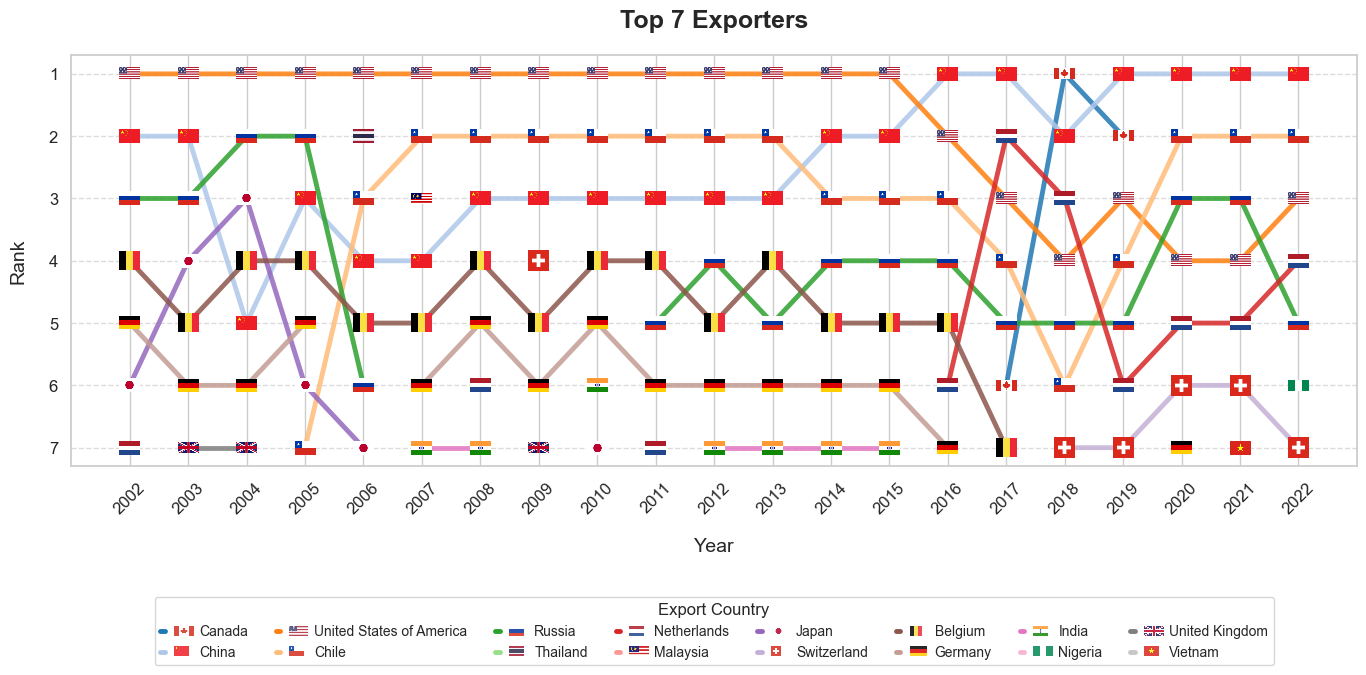

In [63]:
create_bump_chart_with_flags(
    df=df,
    category='export_country',
    top_n=7,
)

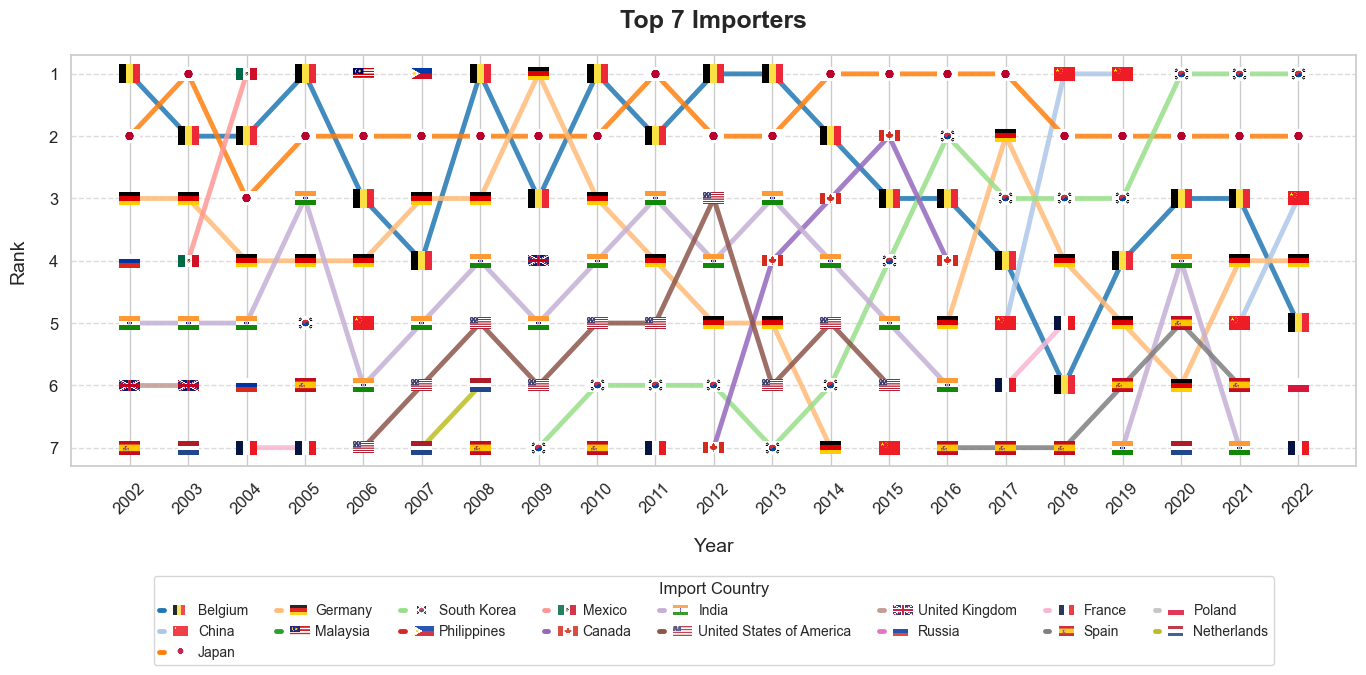

In [64]:
create_bump_chart_with_flags(
    df=df,
    category='import_country',
    top_n=7,
)

### 3) Trade Network Properties

In [65]:
def compute_diameter(G):
    """
    Computes the diameter of the largest connected component of the graph.

    Parameters:
        G (networkx.Graph): Input graph.

    Returns:
        float: Diameter of the largest connected component, or NaN if the graph is empty.

    Interpretation:
        - The diameter is the longest shortest path between any two nodes in the graph.
        - A large diameter indicates a sparse or stretched-out graph, while a small diameter
          suggests a compact or dense graph.
        - For disconnected graphs, the diameter is computed for the largest connected component.
    """
    if G.number_of_nodes() == 0:
        return np.nan
    if nx.is_connected(G):
        return nx.diameter(G)
    else:
        GCC = max(nx.connected_components(G), key=len)
        G_sub = G.subgraph(GCC)
        if G_sub.number_of_nodes() > 1:
            return nx.diameter(G_sub)
        else:
            return 0.0

def compute_degree_assortativity(G):
    """
    Computes the degree assortativity coefficient of the graph.

    Parameters:
        G (networkx.Graph): Input graph.

    Returns:
        float: Degree assortativity coefficient, or NaN if the graph has no edges.

    Interpretation:
        - The degree assortativity measures the tendency of nodes to connect to other nodes
          with a similar degree (number of edges).
        - Values range from -1 to 1:
          - Positive values: High-degree nodes connect to other high-degree nodes.
          - Negative values: High-degree nodes connect to low-degree nodes.
          - Zero: No correlation between degrees of connected nodes.
    """
    if G.number_of_edges() > 0:
        return nx.degree_assortativity_coefficient(G, x='degree')
    else:
        return np.nan

def compute_avg_node_strength(G):
    """
    Computes the average node strength of the graph.

    Parameters:
        G (networkx.Graph): Input graph.

    Returns:
        float: Average node strength, or NaN if the graph is empty.

    Interpretation:
        - Node strength is the sum of the weights of edges connected to a node.
        - The average node strength represents the average amount of interaction (or connection weight)
          per node in the graph.
        - Useful in weighted networks, such as transportation or social interaction graphs.
    """
    if G.number_of_nodes() == 0:
        return np.nan
    strengths = []
    for n in G.nodes():
        strength = sum(d['weight'] for _,_,d in G.edges(n, data=True))
        strengths.append(strength)
    if len(strengths) > 0:
        return np.mean(strengths)
    else:
        return np.nan

def gini_coefficient(values):
    """
    Computes the Gini coefficient of a distribution.

    Parameters:
        values (list or numpy array): Input values.

    Returns:
        float: Gini coefficient, or NaN if the input is empty.

    Interpretation:
        - The Gini coefficient measures inequality in a distribution.
        - Values range from 0 to 1:
          - 0: Perfect equality (all values are the same).
          - 1: Perfect inequality (one value is much larger than the rest).
        - Useful in quantifying the distribution of resources or connectivity in a network.
    """
    arr = np.sort(values)
    n = len(arr)
    if n == 0:
        return np.nan

    cumulative = np.cumsum(arr)
    sum_arr = cumulative[-1]
    if sum_arr == 0:
        return 0.0

    rel_cumulative = cumulative / sum_arr
    return (n + 1 - 2 * np.sum(rel_cumulative) / n)

def compute_gini_node_strength(G):
    """
    Computes the Gini coefficient of node strength in the graph.

    Parameters:
        G (networkx.Graph): Input graph.

    Returns:
        float: Gini coefficient of node strength, or NaN if the graph is empty.

    Interpretation:
        - Measures inequality in the distribution of node strength (sum of edge weights per node).
        - High Gini coefficient: Strength is concentrated in a few nodes (high inequality).
        - Low Gini coefficient: Strength is evenly distributed across nodes (low inequality).
    """
    if G.number_of_nodes() == 0:
        return np.nan
    strengths = [sum(d['weight'] for _,_,d in G.edges(n, data=True)) for n in G.nodes()]
    if len(strengths) == 0:
        return np.nan
    return gini_coefficient(strengths)

def compute_fraction_bridges(G):
    """
    Computes the fraction of edges in the graph that are bridges.

    Parameters:
        G (networkx.Graph): Input graph.

    Returns:
        float: Fraction of edges that are bridges.

    Interpretation:
        - A bridge is an edge whose removal increases the number of connected components in the graph.
        - The fraction of bridges indicates the structural importance of edges in maintaining connectivity.
        - A high fraction suggests a fragile network where many edges are critical for connectivity.
    """
    if G.number_of_edges() == 0:
        return 0.0
    bridges = list(nx.bridges(G))
    return len(bridges) / G.number_of_edges()


In [66]:
results = {
    'year': [],
    'num_nodes': [],
    'num_edges': [],
    'density': [],
    'avg_clustering': [],
    'avg_shortest_path': [],
    'modularity': [],
    'num_communities': [],
    'diameter': [],
    'degree_assortativity': [],
    'avg_node_strength': [],
    'gini_node_strength': [],
    'fraction_bridges': [],
}

for year, graph in yearly_graphs.items():
    num_nodes = graph.number_of_nodes()
    num_edges = graph.number_of_edges()
    density = nx.density(graph)

    avg_clustering = nx.average_clustering(graph)

    if nx.is_connected(graph):
        avg_shortest_path = nx.average_shortest_path_length(graph)
    else:
        largest_cc = max(nx.connected_components(graph), key=len)
        largest_subgraph = graph.subgraph(largest_cc)
        avg_shortest_path = nx.average_shortest_path_length(largest_subgraph)

    partition = community_louvain.best_partition(graph, weight='weight')
    modularity = community_louvain.modularity(partition, graph, weight='weight')
    num_communities = len(set(partition.values()))

    diameter = compute_diameter(graph)
    degree_assortativity = compute_degree_assortativity(graph)
    avg_node_strength = compute_avg_node_strength(graph)
    gini_node_strength = compute_gini_node_strength(graph)
    fraction_bridges = compute_fraction_bridges(graph)

    results['year'].append(year)
    results['num_nodes'].append(num_nodes)
    results['num_edges'].append(num_edges)
    results['density'].append(density)
    results['avg_clustering'].append(avg_clustering)
    results['avg_shortest_path'].append(avg_shortest_path)
    results['modularity'].append(modularity)
    results['num_communities'].append(num_communities)
    results['diameter'].append(diameter)
    results['degree_assortativity'].append(degree_assortativity)
    results['avg_node_strength'].append(avg_node_strength)
    results['gini_node_strength'].append(gini_node_strength)
    results['fraction_bridges'].append(fraction_bridges)

results_df = pd.DataFrame(results)


In [67]:
def plot_metric(data, x_col, y_col, title, color="black", marker='o', figsize=(10, 6), degree=2):
    """
    Plots a metric with an optional polynomial trend line.

    Parameters:
        data (pd.DataFrame): Input DataFrame containing the data.
        x_col (str): Column name for the x-axis.
        y_col (str): Column name for the y-axis.
        title (str): Title of the plot.
        color (str): Line color for the metric plot.
        marker (str): Marker style for the metric plot.
        figsize (tuple): Figure size (width, height).
        degree (int): Degree of the polynomial trend line (default is 2).
    """
    sns.set_theme(style="ticks")
    plt.rcParams.update({
        "font.family": "Arial",
        "mathtext.fontset": "stix",
        "axes.labelsize": 14,
        "axes.titlesize": 16,
        "xtick.labelsize": 12,
        "ytick.labelsize": 12,
        "legend.fontsize": 12,
        "axes.linewidth": 1.2,
        "grid.linewidth": 0.8
    })

    plt.figure(figsize=figsize)

    sns.lineplot(data=data, x=x_col, y=y_col, marker=marker, color=color, linewidth=1.5, label='Metric')

    x = data[x_col].astype(float)
    y = data[y_col].astype(float)
    poly_coeffs = np.polyfit(x, y, degree)
    poly_func = np.poly1d(poly_coeffs)
    x_fit = np.linspace(x.min(), x.max(), 500)
    y_fit = poly_func(x_fit)

    plt.plot(x_fit, y_fit, color='red', linestyle='--', linewidth=1.5, label=f'Polynomial Trend (Degree {degree})')

    plt.title(title, fontsize=16, fontweight="bold", pad=20)
    plt.xlabel(x_col.replace("_", " ").title(), fontsize=14)
    plt.ylabel(y_col.replace("_", " ").title(), fontsize=14)
    plt.xticks(data[x_col].unique().astype(int), rotation=45)
    plt.grid(visible=True, linestyle="--", linewidth=0.8, alpha=0.7)
    sns.despine()
    plt.legend(fontsize=12, loc='best')
    plt.tight_layout()

    filename = f"{hs_label}_{'_'.join(title.split()).lower()}.png"
    plt.savefig(os.path.join("graphics", hs_label, filename), dpi=300, bbox_inches="tight", format="png")
    plt.show()


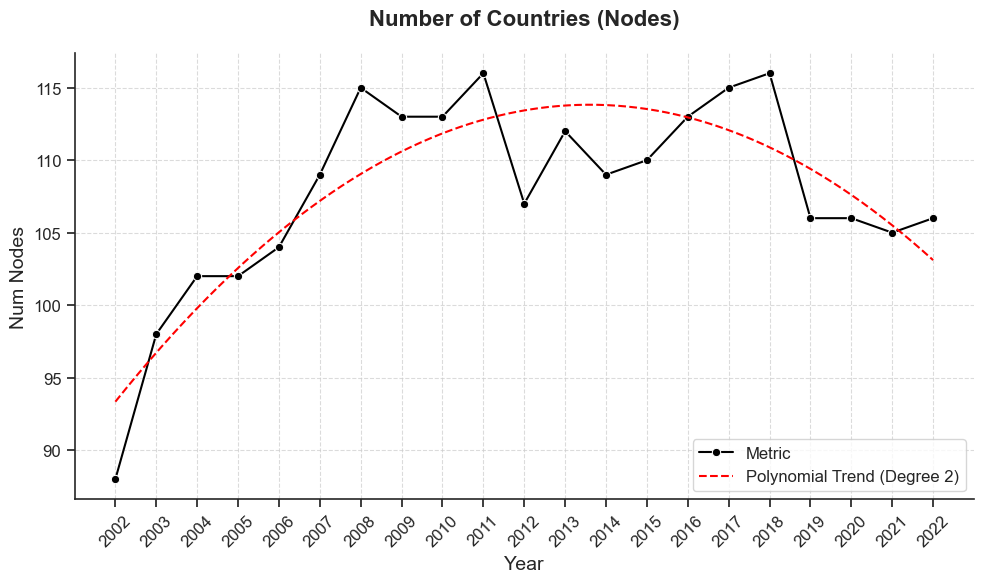

In [68]:
plot_metric(
    data=results_df,
    x_col='year',
    y_col='num_nodes',
    title="Number of Countries (Nodes)"
)

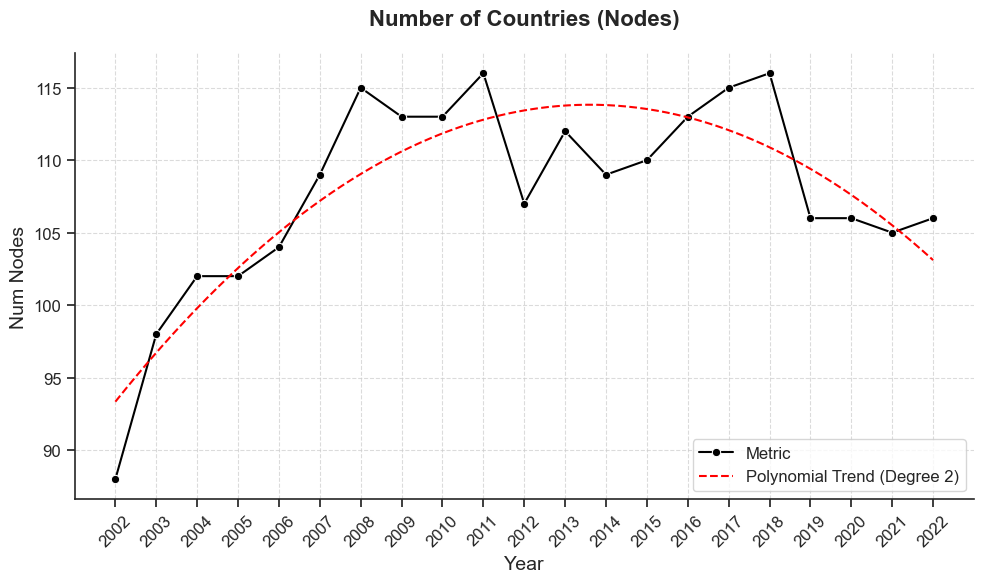

In [69]:
plot_metric(
    data=results_df,
    x_col='year',
    y_col='num_nodes',
    title="Number of Countries (Nodes)"
)

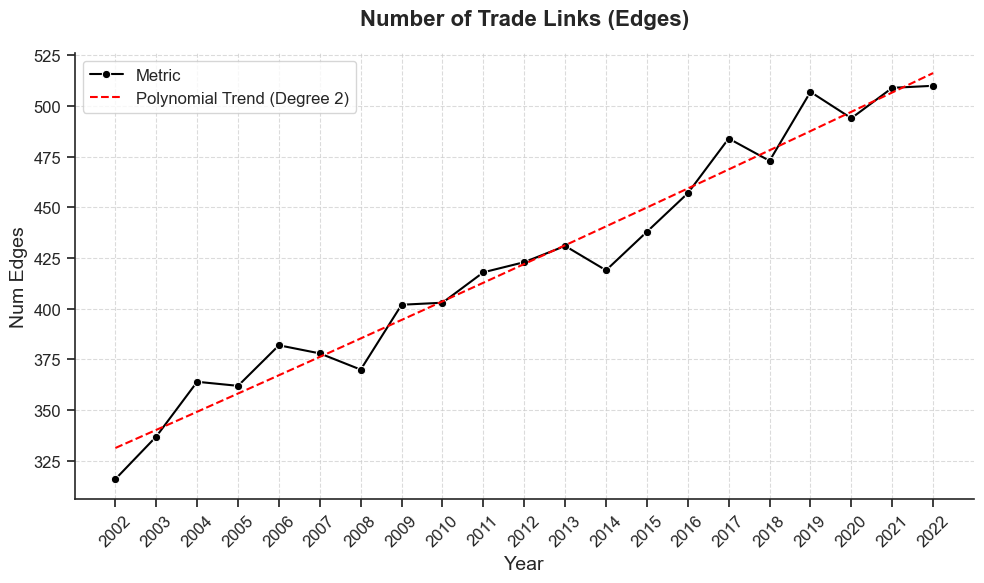

In [70]:
plot_metric(
    data=results_df,
    x_col='year',
    y_col='num_edges',
    title="Number of Trade Links (Edges)"
)

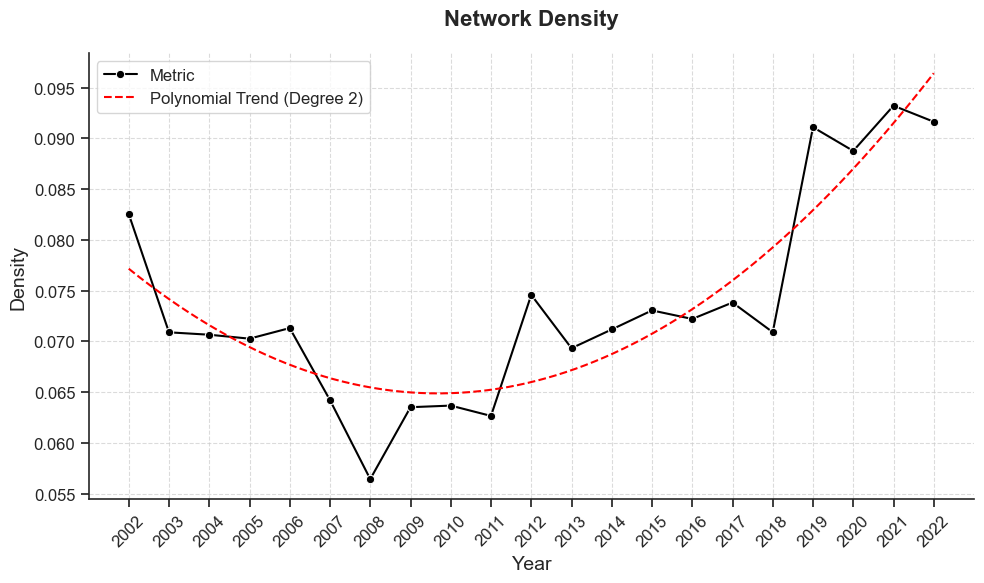

In [71]:
plot_metric(
    data=results_df,
    x_col='year',
    y_col='density',
    title="Network Density"
)

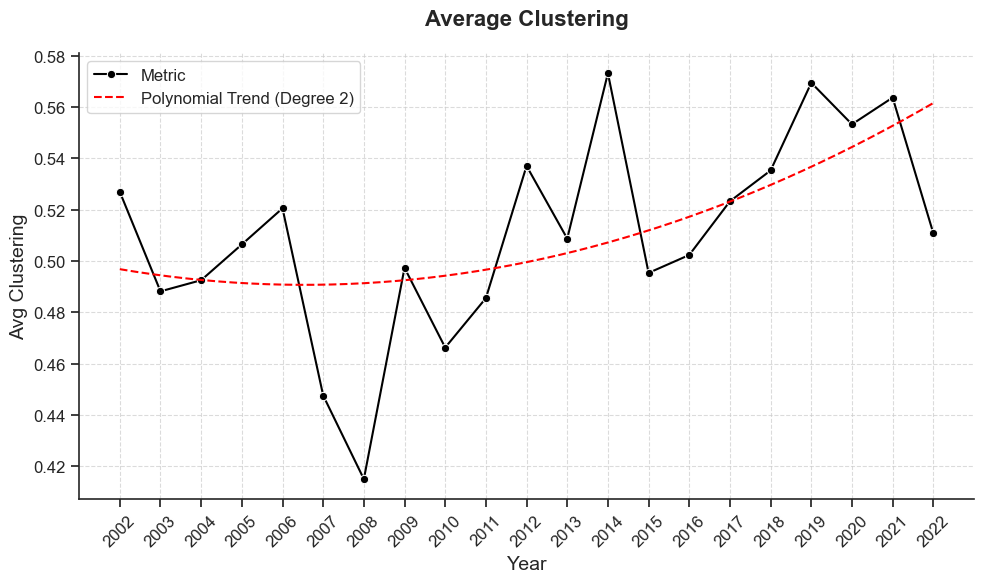

In [72]:
plot_metric(
    data=results_df,
    x_col='year',
    y_col='avg_clustering',
    title="Average Clustering"
)

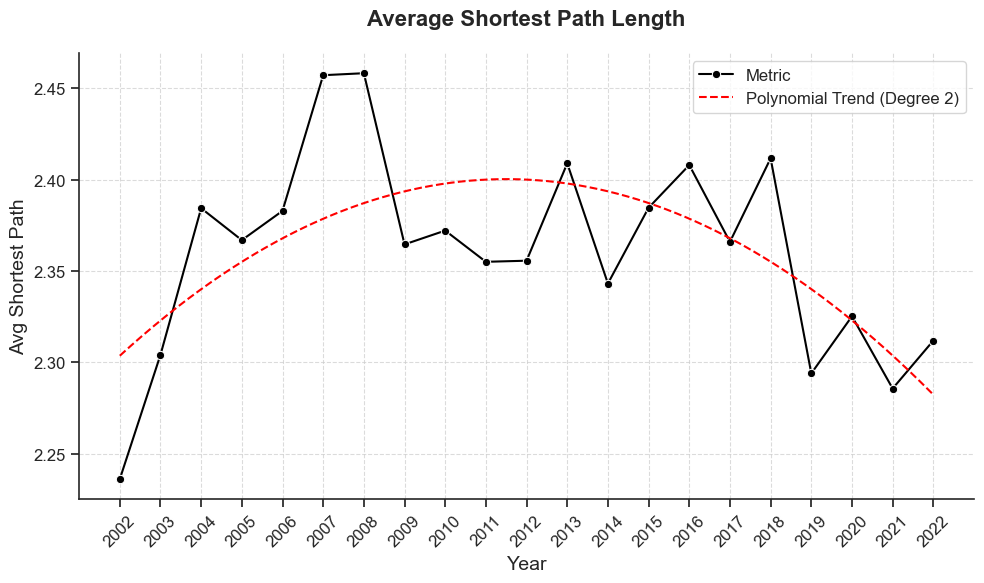

In [73]:
plot_metric(
    data=results_df,
    x_col='year',
    y_col='avg_shortest_path',
    title="Average Shortest Path Length"
)

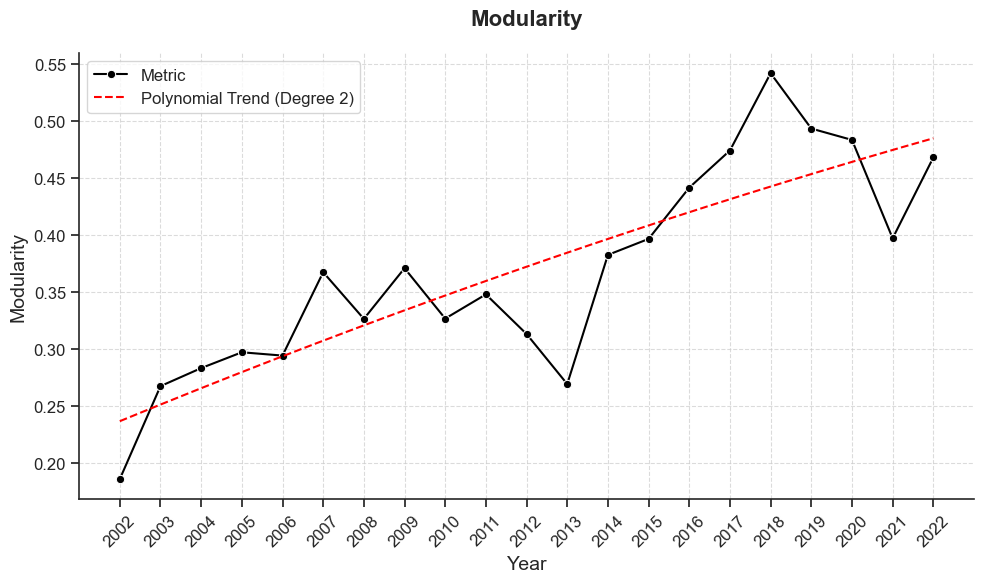

In [74]:
plot_metric(
    data=results_df,
    x_col='year',
    y_col='modularity',
    title="Modularity"
)

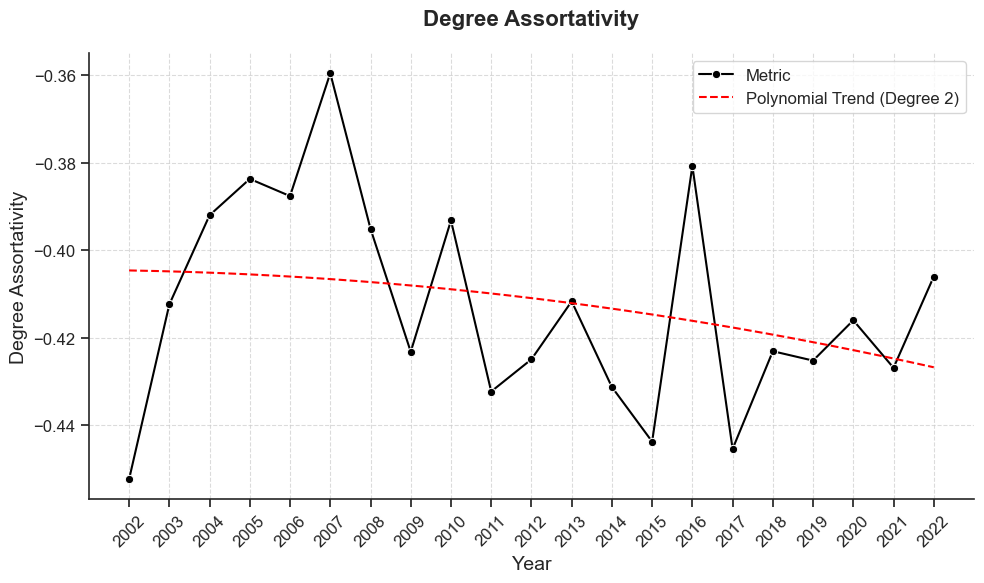

In [75]:
plot_metric(
    data=results_df,
    x_col='year',
    y_col='degree_assortativity',
    title="Degree Assortativity"
)

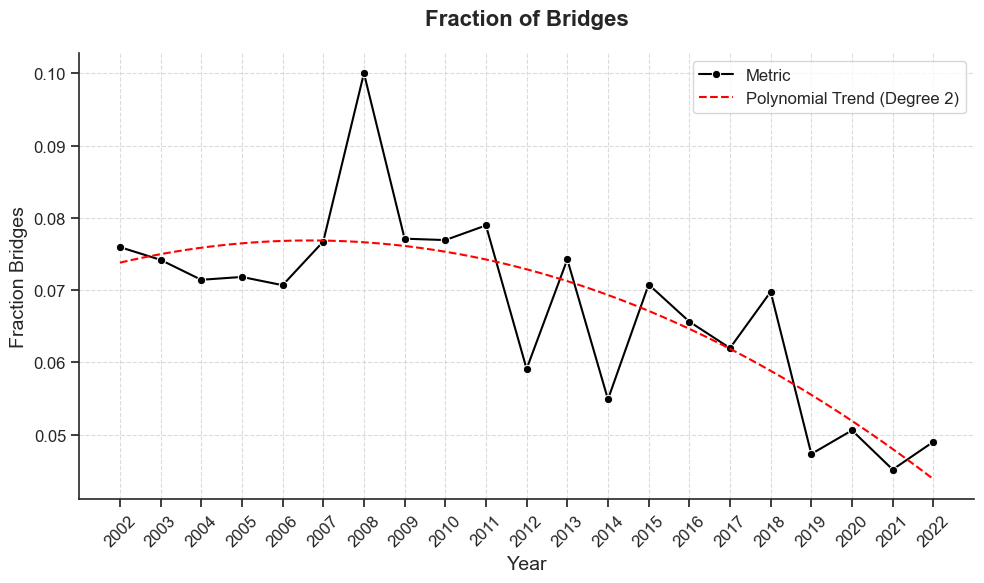

In [76]:
plot_metric(
    data=results_df,
    x_col='year',
    y_col='fraction_bridges',
    title="Fraction of Bridges"
)

### 4) Map Visualization of Node Specific Trade Flow

In [77]:
gray_blue_cmap = mcolors.LinearSegmentedColormap.from_list(
    "gray_blue",
    ["gray", "blue"]
)

gray_red_cmap = mcolors.LinearSegmentedColormap.from_list(
    "gray_red",
    ["gray", "red"]
)

In [78]:
def preprocess():
    shapefile_path = os.path.join("dataset", "110m_cultural", "ne_110m_admin_0_countries.shp")
    world = gpd.read_file(shapefile_path)
    valid_countries = world['ADMIN'].tolist()

    export_data = df.groupby('export_country')['v'].sum().reset_index()
    import_data = df.groupby('import_country')['v'].sum().reset_index()

    export_data['export_country'] = normalize_country_names(export_data, 'export_country')
    import_data['import_country'] = normalize_country_names(import_data, 'import_country')

    unmatched_exports = set(export_data['export_country']) - set(valid_countries)
    unmatched_imports = set(import_data['import_country']) - set(valid_countries)

    if unmatched_exports:
        export_mapping = generate_fuzzy_mapping(unmatched_exports, valid_countries)
        export_data['export_country'] = export_data['export_country'].replace(export_mapping)
        print(f"Unmapped Names: {', '.join([name for name in export_mapping.keys() if not export_mapping[name]])}")


    if unmatched_imports:
        import_mapping = generate_fuzzy_mapping(unmatched_imports, valid_countries)
        import_data['import_country'] = import_data['import_country'].replace(import_mapping)
        print(f"Unmapped Names: {', '.join([name for name in import_mapping.keys() if not import_mapping[name]])}")

    export_data = export_data.groupby('export_country')['v'].sum().reset_index()
    import_data = import_data.groupby('import_country')['v'].sum().reset_index()

    world_export = world.merge(export_data, left_on="ADMIN", right_on="export_country", how="left")
    world_import = world.merge(import_data, left_on="ADMIN", right_on="import_country", how="left")

    return world_export, world_import


Unmapped Names: Andorra, Curaçao, Barbados, Cook Isds, Singapore
Unmapped Names: Br. Virgin Isds, Bahrain, Montserrat, Maldives, Cabo Verde, Singapore, Barbados, Côte d'Ivoire, Kiribati, Comoros, Samoa, Lao People's Dem. Rep., Palau, Cayman Isds, Bermuda, Seychelles, Andorra


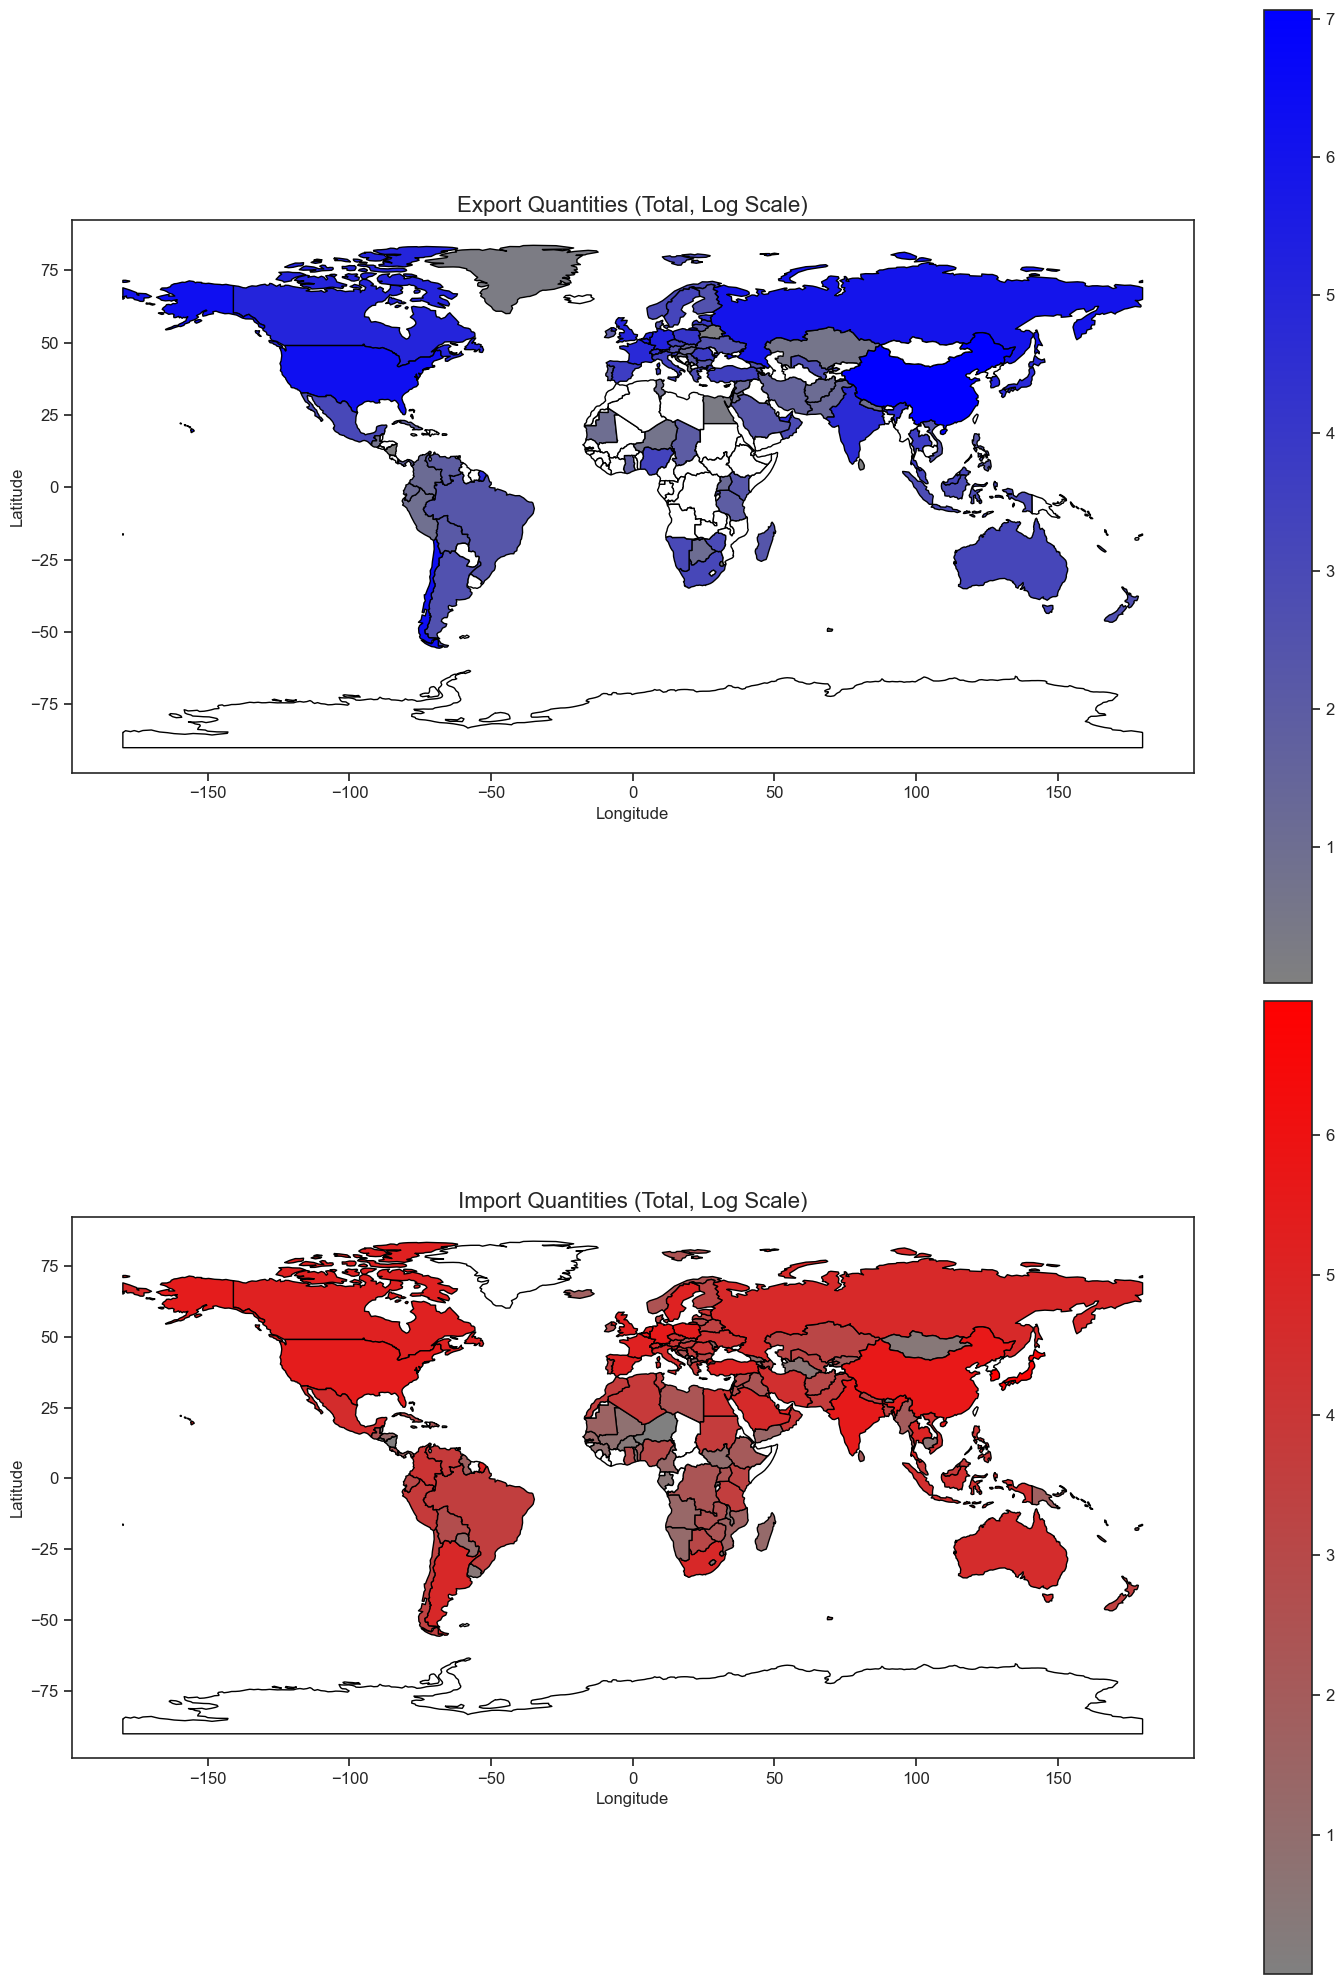

In [79]:
def plot_map():
    world_export, world_import = preprocess()

    world_export["v"] = np.log10(world_export["v"] + 1)
    world_import["v"] = np.log10(world_import["v"] + 1)

    fig, ax = plt.subplots(nrows=2, ncols=1, figsize=(15, 20))
    fig.patch.set_facecolor('white')
    for a in ax:
        a.set_facecolor('white')

    world_export.plot(
        column="v",
        cmap=gray_blue_cmap,
        legend=True,
        ax=ax[0],
        missing_kwds={"color": "white"},
        edgecolor="black"
    )
    ax[0].set_title(f"Export Quantities (Total, Log Scale)", fontsize=16)
    ax[0].set_xlabel("Longitude", fontsize=12)
    ax[0].set_ylabel("Latitude", fontsize=12)

    world_import.plot(
        column="v",
        cmap=gray_red_cmap,
        legend=True,
        ax=ax[1],
        missing_kwds={"color": "white"},
        edgecolor="black"
    )
    ax[1].set_title(f"Import Quantities (Total, Log Scale)", fontsize=16)
    ax[1].set_xlabel("Longitude", fontsize=12)
    ax[1].set_ylabel("Latitude", fontsize=12)

    plt.tight_layout()
    plt.savefig(os.path.join("graphics", hs_label, f"{hs_label}_net_export_map_vertical.png"), dpi=300, facecolor='white')
    plt.show()

plot_map()


Unmapped Names: Andorra, Curaçao, Barbados, Cook Isds, Singapore
Unmapped Names: Br. Virgin Isds, Bahrain, Montserrat, Maldives, Cabo Verde, Singapore, Barbados, Côte d'Ivoire, Kiribati, Comoros, Samoa, Lao People's Dem. Rep., Palau, Cayman Isds, Bermuda, Seychelles, Andorra


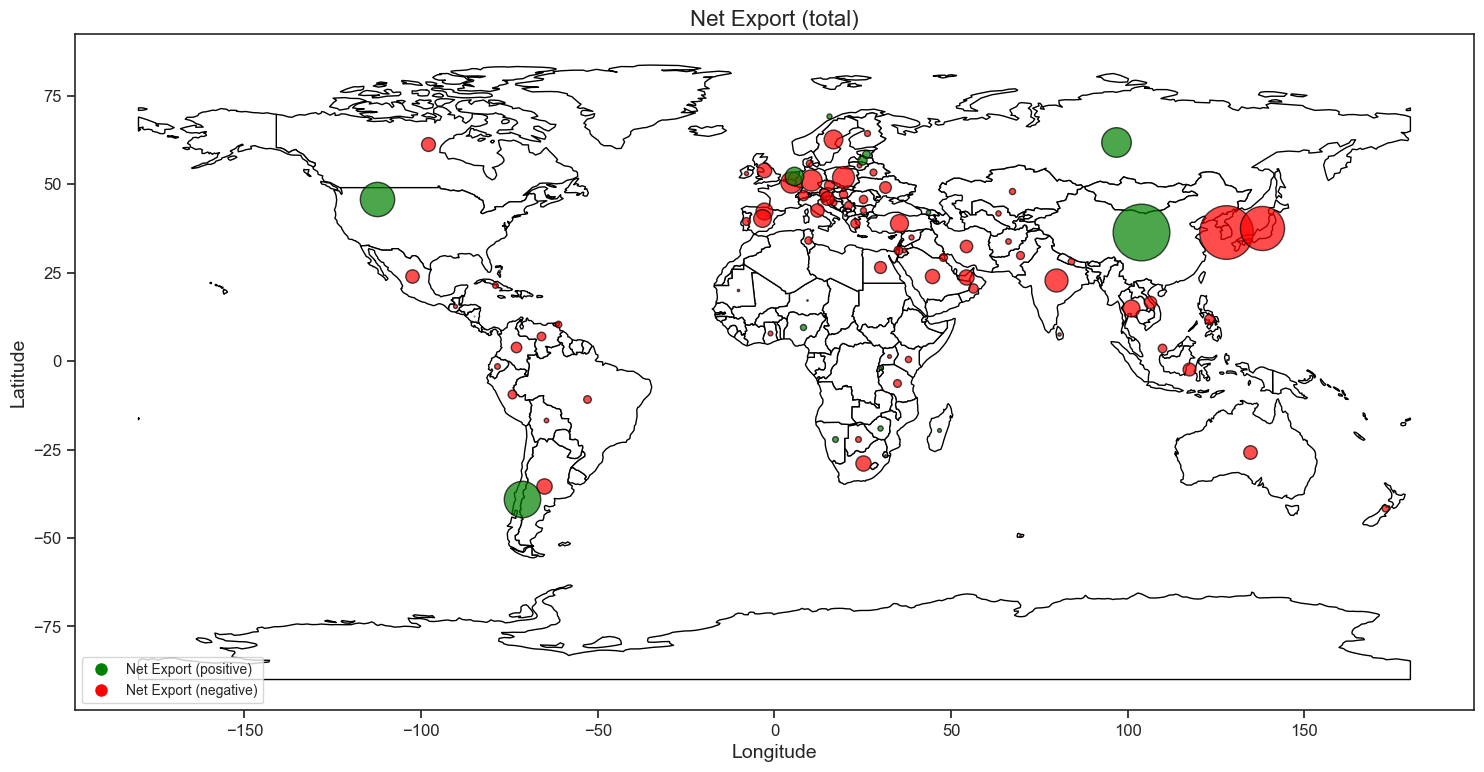

In [80]:
def plot_map_2():
    shapefile_path = os.path.join("dataset", "110m_cultural", "ne_110m_admin_0_countries.shp")
    world = gpd.read_file(shapefile_path)
    world_export, world_import = preprocess()

    net_export = (
        world_export.set_index("export_country")["v"]
        - world_import.set_index("import_country")["v"]
    ).reset_index()
    net_export.columns = ["country", "net_export"]

    world_net = world.merge(net_export, left_on="ADMIN", right_on="country", how="left")

    fig, ax = plt.subplots(1, 1, figsize=(15, 10))

    world.plot(ax=ax, color="white", edgecolor="black")
    ax.set_facecolor('none')

    for _, row in world_net.iterrows():
        if pd.notnull(row["net_export"]) and row["net_export"] != 0:
            size = np.sqrt(abs(row["net_export"])) / 2
            color = "green" if row["net_export"] > 0 else "red"
            ax.scatter(
                row.geometry.centroid.x,
                row.geometry.centroid.y,
                s=size,
                color=color,
                alpha=0.7,
                edgecolor="black"
            )

    handles = [
        plt.Line2D([0], [0], marker="o", color="w", markerfacecolor="green", markersize=10, label="Net Export (positive)"),
        plt.Line2D([0], [0], marker="o", color="w", markerfacecolor="red", markersize=10, label="Net Export (negative)"),
    ]
    ax.legend(handles=handles, loc="lower left", fontsize="small")

    ax.set_title(f"Net Export (total)")
    ax.set_xlabel("Longitude")
    ax.set_ylabel("Latitude")

    plt.tight_layout()
    plt.savefig(os.path.join("graphics", hs_label, f"{hs_label}_net_export_map_2.png"), dpi=300, transparent=True)
    plt.show()

plot_map_2()


Unmapped Names: Andorra, Curaçao, Barbados, Cook Isds, Singapore
Unmapped Names: Br. Virgin Isds, Bahrain, Montserrat, Maldives, Cabo Verde, Singapore, Barbados, Côte d'Ivoire, Kiribati, Comoros, Samoa, Lao People's Dem. Rep., Palau, Cayman Isds, Bermuda, Seychelles, Andorra


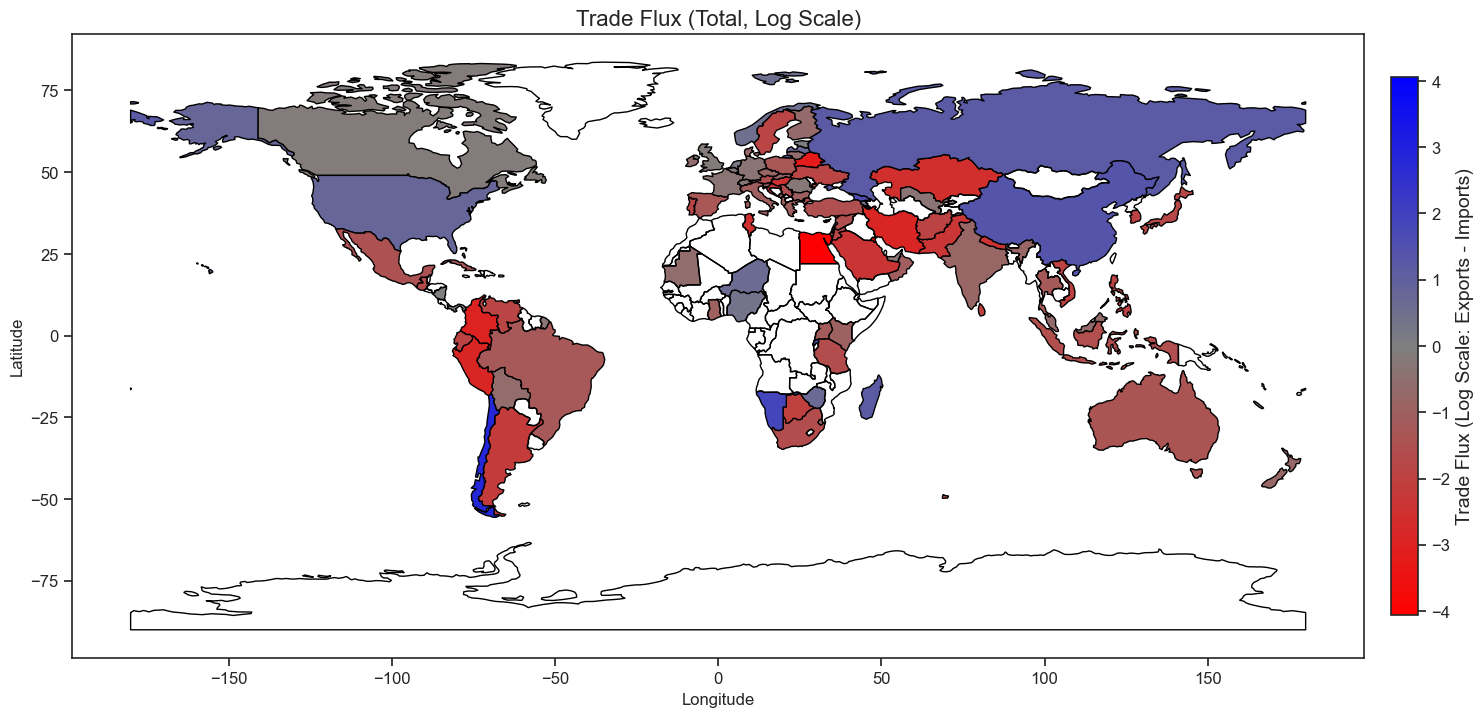

In [81]:
def plot_flux():
    world_export, world_import = preprocess()

    world_export["v"] = np.log10(world_export["v"] + 1)
    world_import["v"] = np.log10(world_import["v"] + 1)

    world_flux = world_export[["ADMIN", "geometry", "v"]].merge(
        world_import[["ADMIN", "v"]], on="ADMIN", suffixes=("_exp", "_imp")
    )
    world_flux["flux"] = world_flux["v_exp"] - world_flux["v_imp"]

    vmax = world_flux["flux"].abs().max()

    flux_cmap = mcolors.LinearSegmentedColormap.from_list("flux_cmap", ["red", "gray", "blue"])
    norm = mcolors.Normalize(vmin=-vmax, vmax=vmax)

    fig, ax = plt.subplots(1, 1, figsize=(15, 10))
    fig.patch.set_alpha(0)
    ax.set_facecolor((0, 0, 0, 0))

    world_flux.plot(
        column="flux",
        cmap=flux_cmap,
        norm=norm,
        legend=False,
        ax=ax,
        missing_kwds={"color": "none"},
        edgecolor="black"
    )

    sm = plt.cm.ScalarMappable(norm=norm, cmap=flux_cmap)
    sm.set_array([])
    cbar = fig.colorbar(sm, ax=ax, orientation="vertical", fraction=0.02, pad=0.02)
    cbar.set_label("Trade Flux (Log Scale: Exports - Imports)")

    ax.set_title(f"Trade Flux (Total, Log Scale)", fontsize=16)
    ax.set_xlabel("Longitude", fontsize=12)
    ax.set_ylabel("Latitude", fontsize=12)

    plt.tight_layout()
    plt.savefig(
        os.path.join("graphics", hs_label, f"{hs_label}_trade_flux_map.png"),
        dpi=300,
        transparent=True
    )
    plt.show()

plot_flux()


### 5) Theoretical Graph Properties

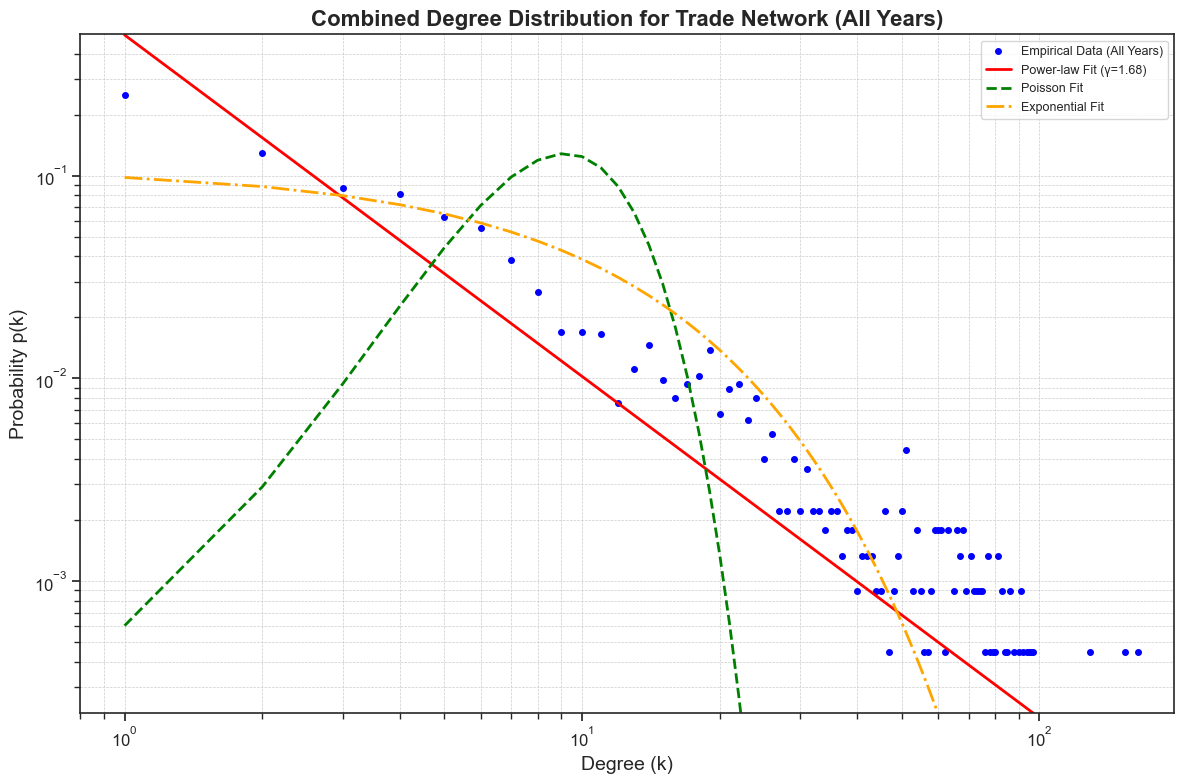

In [82]:
def compute_country_statistics(df):
    export_stats = df.groupby(["t", "export_country"])["q"].size().reset_index(name="num_exports")
    import_stats = df.groupby(["t", "import_country"])["q"].size().reset_index(name="num_imports")

    country_stats = pd.merge(
        export_stats,
        import_stats,
        left_on=["t", "export_country"],
        right_on=["t", "import_country"],
        how="outer"
    ).fillna(0)

    country_stats.rename(columns={"export_country": "country", "import_country": "country"}, inplace=True)

    country_stats["degree"] = country_stats["num_exports"] + country_stats["num_imports"]

    return country_stats[["t", "country", "degree"]]

def plot_degree_distribution_combined(df, name):
    # Combine degree sequences from all years
    degree_sequence = df["degree"].values
    k_values, counts = np.unique(degree_sequence, return_counts=True)
    probs = counts / counts.sum()

    nonzero = probs > 0
    k_values = k_values[nonzero]
    probs = probs[nonzero]

    fig, ax = plt.subplots(figsize=(12, 8))

    # Plot combined degree distribution
    ax.loglog(k_values, probs, 'o', label="Empirical Data (All Years)", color='blue', markersize=4)

    # Power-law fit
    gamma = 1 + len(degree_sequence) / np.sum(np.log(degree_sequence / degree_sequence.min()))
    y_powerlaw = k_values ** (-gamma)
    y_powerlaw /= y_powerlaw.sum()  # Normalize
    ax.loglog(k_values, y_powerlaw, label=f"Power-law Fit (γ={gamma:.2f})", color='red', linewidth=2)

    # Poisson fit
    lambda_poisson = np.mean(degree_sequence)
    y_poisson = stats.poisson.pmf(k_values, lambda_poisson)
    y_poisson /= y_poisson.sum()  # Normalize
    ax.loglog(k_values, y_poisson, label="Poisson Fit", color='green', linestyle='--', linewidth=2)

    # Exponential fit
    y_exponential = (1 / lambda_poisson) * np.exp(-k_values / lambda_poisson)
    y_exponential /= y_exponential.sum()  # Normalize
    ax.loglog(k_values, y_exponential, label="Exponential Fit", color='orange', linestyle='-.', linewidth=2)

    ax.set_xlim([0.8 * k_values.min(), k_values.max() * 1.2])
    ax.set_ylim([0.5 * probs.min(), probs.max() * 2])

    ax.set_xlabel("Degree (k)")
    ax.set_ylabel("Probability p(k)")
    ax.set_title(f"Combined Degree Distribution for {name} (All Years)", fontweight='bold')
    ax.legend(fontsize=9)
    ax.grid(True, which="both", linestyle="--", linewidth=0.5)

    plt.tight_layout()
    plt.savefig(
        os.path.join("graphics", hs_label, f"{hs_label}_degree_distribution_centrality.png"),
        dpi=300,
        transparent=True
    )
    plt.show()


country_stats = compute_country_statistics(df)

plot_degree_distribution_combined(country_stats, "Trade Network")


### 6) Centrality Analysis


Centrality Distributions and Summary Statistics for Lithium Trade Network:

Heterogeneity parameter: 2.6648

Degree Centrality:
Mean: 9.3208, Median: 5.0000, Std Dev: 12.0263, Max: 56.0000, Min: 1.0000
Proportion of zeros: 0.00%

Closeness Centrality:
Mean: 0.4427, Median: 0.4312, Std Dev: 0.0766, Max: 0.6562, Min: 0.2975
Proportion of zeros: 0.00%

Betweenness Centrality:
Mean: 0.0127, Median: 0.0000, Std Dev: 0.0333, Max: 0.1949, Min: 0.0000
Proportion of zeros: 45.28%

Eigenvector Centrality:
Mean: 0.0688, Median: 0.0468, Std Dev: 0.0685, Max: 0.2845, Min: 0.0014
Proportion of zeros: 0.00%



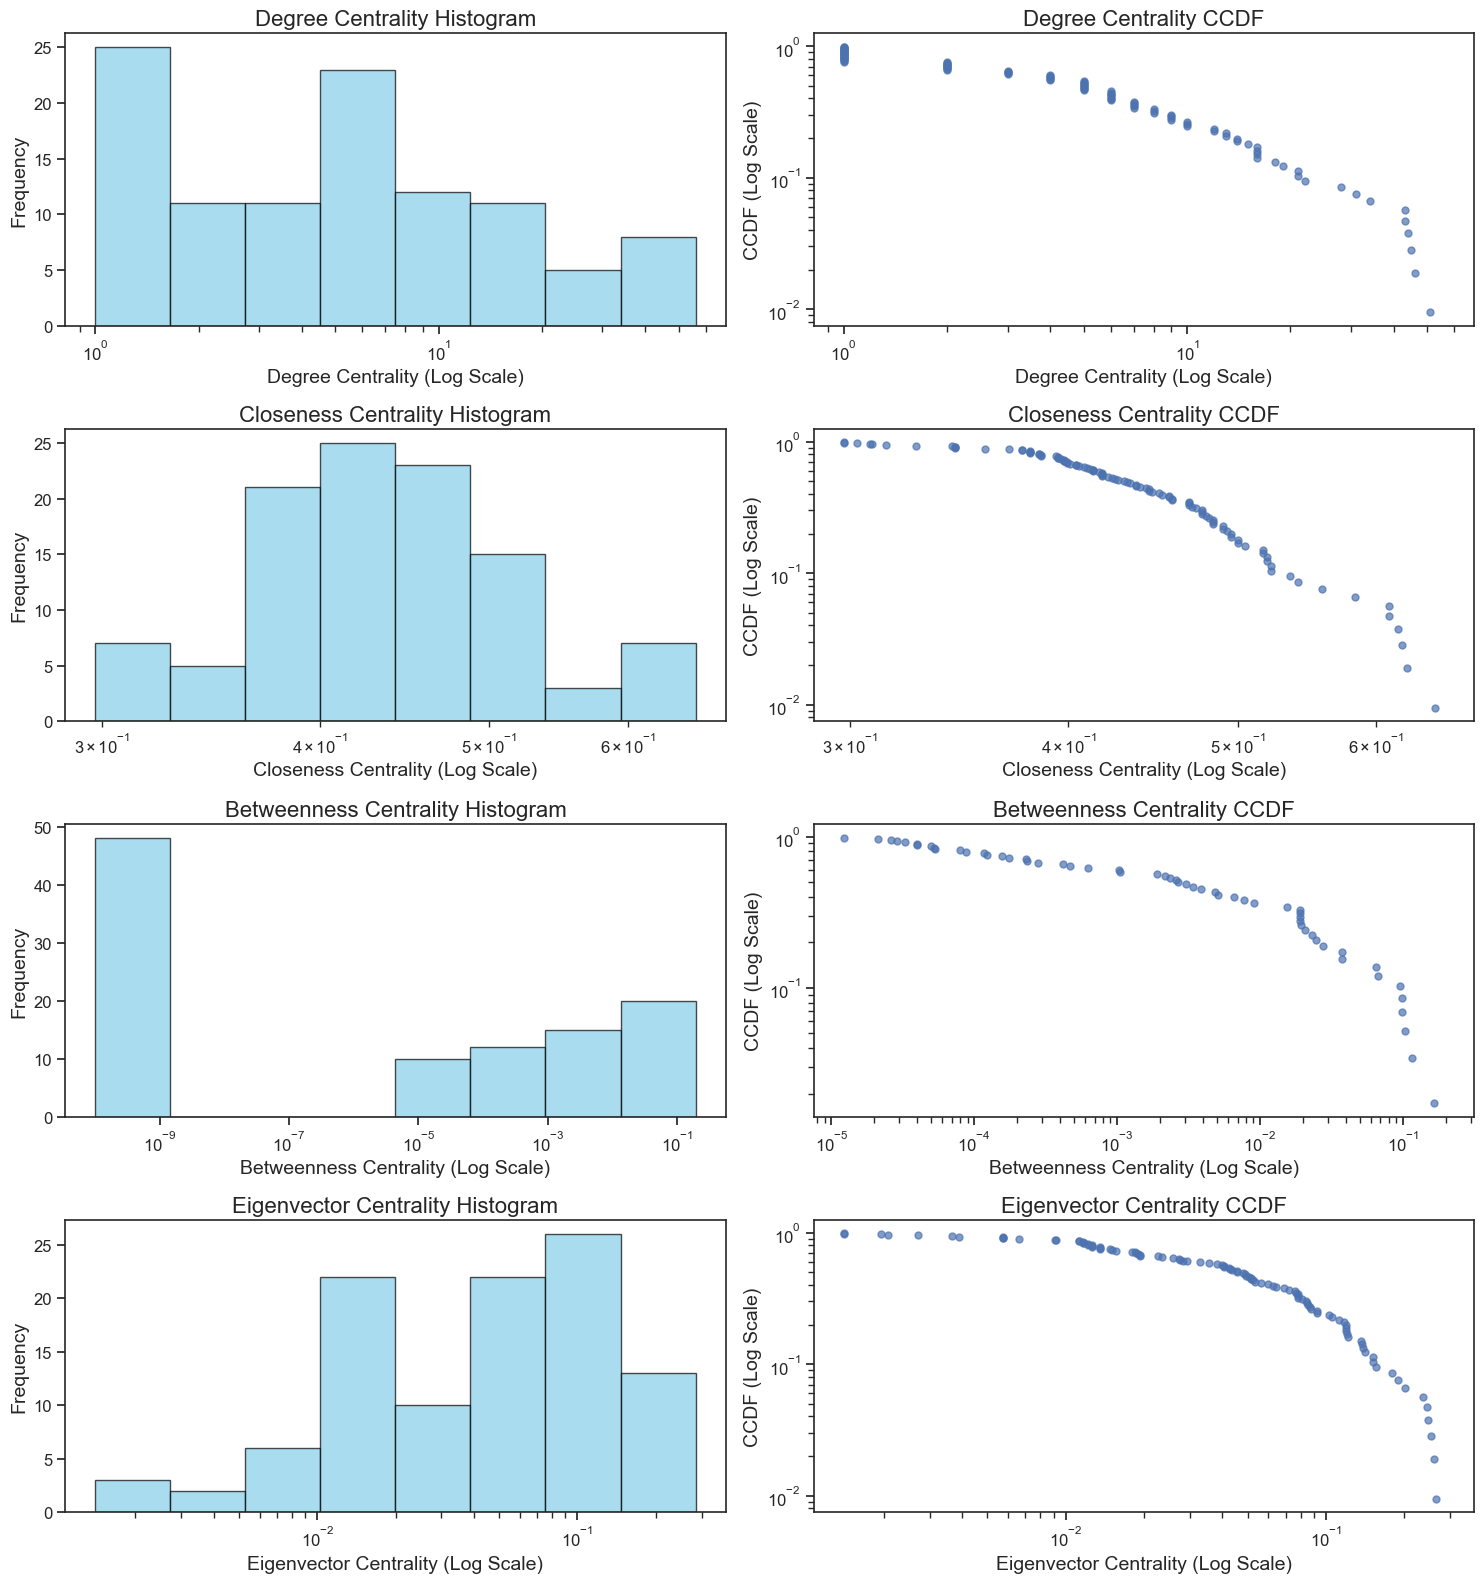

In [83]:
def compare_centralities(G):
    graph_name = "Lithium Trade Network"

    degrees = dict(G.degree())
    mean_degree = np.mean(list(degrees.values()))
    mean_degree_squared = np.mean(np.square(list(degrees.values())))
    heterogeneity = mean_degree_squared / (mean_degree ** 2)
    closeness_centralities = nx.closeness_centrality(G)
    betweenness_centralities = nx.betweenness_centrality(G)
    eigenvector_centralities = nx.eigenvector_centrality(G, max_iter=1000)

    centrality_measures = {
        "Degree": degrees,
        "Closeness": closeness_centralities,
        "Betweenness": betweenness_centralities,
        "Eigenvector": eigenvector_centralities
    }

    centrality_values = {k: list(v.values()) for k, v in centrality_measures.items()}

    centrality_names = list(centrality_measures.keys())
    N_ROWS = len(centrality_names)
    fig1, axes1 = plt.subplots(N_ROWS, 2, figsize=(15, 4 * N_ROWS))
    if N_ROWS == 1:
        axes1 = [axes1]

    print(f"\nCentrality Distributions and Summary Statistics for {graph_name}:\n")
    print(f"Heterogeneity parameter: {heterogeneity:.4f}\n")
    for i, centrality_name in enumerate(centrality_names):
        values = centrality_values[centrality_name]

        mean_val = np.mean(values)
        median_val = np.median(values)
        std_val = np.std(values)
        max_val = np.max(values)
        min_val = np.min(values)
        zero_count = values.count(0)
        zero_proportion = zero_count / len(values)
        print(f"{centrality_name} Centrality:")
        print(f"Mean: {mean_val:.4f}, Median: {median_val:.4f}, Std Dev: {std_val:.4f}, "
              f"Max: {max_val:.4f}, Min: {min_val:.4f}")
        print(f"Proportion of zeros: {zero_proportion:.2%}\n")

        ax_hist = axes1[i][0]
        epsilon = 1e-10
        adjusted_values = [v if v > 0 else epsilon for v in values]
        num_bins = int(2 * len(adjusted_values) ** (1/3))  # Rice Rule
        bins = np.logspace(np.log10(min(adjusted_values)), np.log10(max(adjusted_values)), num_bins)
        ax_hist.hist(adjusted_values, bins=bins, color='skyblue', edgecolor='black', alpha=0.7)
        ax_hist.set_xscale('log')
        ax_hist.set_xlabel(f"{centrality_name} Centrality (Log Scale)")
        ax_hist.set_ylabel("Frequency")
        ax_hist.set_title(f"{centrality_name} Centrality Histogram")
        ax_ccdf = axes1[i][1]
        positive_values = [v for v in values if v > 0]

        sorted_values = np.sort(positive_values)
        ccdf = 1.0 - np.arange(1, len(sorted_values) + 1) / len(sorted_values)

        ax_ccdf.plot(sorted_values, ccdf, marker='o', linestyle='none', markersize=5, alpha=0.7)
        ax_ccdf.set_xscale('log')
        ax_ccdf.set_yscale('log')
        ax_ccdf.set_xlabel(f"{centrality_name} Centrality (Log Scale)")
        ax_ccdf.set_ylabel("CCDF (Log Scale)")
        ax_ccdf.set_title(f"{centrality_name} Centrality CCDF")

    plt.tight_layout()
    plt.savefig(
        os.path.join("graphics", hs_label, f"{hs_label}_centrality_analysis.png"),
        dpi=300,
        transparent=True
    )
    plt.show()

compare_centralities(yearly_graphs[2020])

### Community Detection

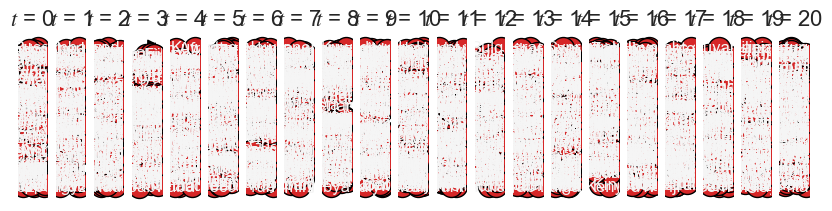

In [84]:
TG = tx.TemporalMultiDiGraph()

for year, G in yearly_graphs.items():
    for u, v in G.edges():
        TG.add_edge(u, v, time=year)

TG = TG.slice(attr="time")

tx.draw(TG, figsize=(8, 2))


In [85]:
snapshots = TG.to_snapshots("igraph")

temporal_membership, improvement = la.find_partition_temporal(
    snapshots,
    la.ModularityVertexPartition,
    interslice_weight=5,
    n_iterations=-1,
    seed=42,
    vertex_id_attr="_nx_name"
)

cmap = plt.cm.get_cmap("tab10")
max_community = max(max(membership) for membership in temporal_membership)  # No .values()
community_colors = {i: mcolors.to_hex(cmap(i / max_community)) for i in range(max_community + 1)}


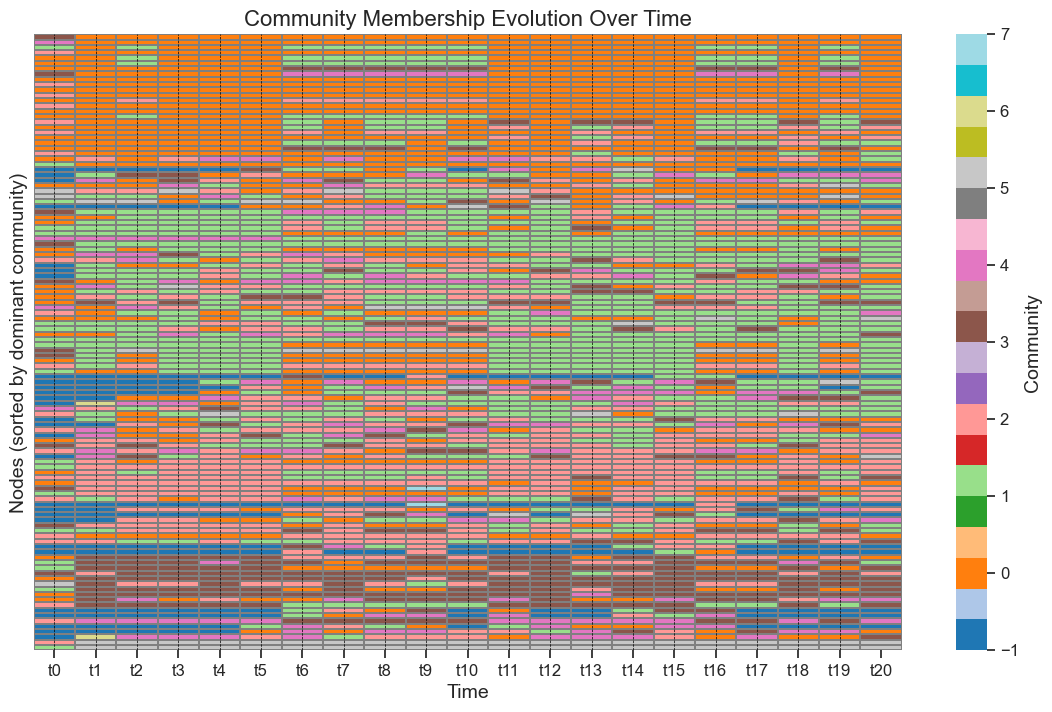

In [86]:
all_nodes = set()
for membership in temporal_membership:
    all_nodes.update(range(len(membership)))

all_nodes = sorted(all_nodes)
node_to_index = {node: i for i, node in enumerate(all_nodes)}

node_community_matrix = np.full((len(all_nodes), len(temporal_membership)), -1)

for t, membership in enumerate(temporal_membership):
    for node, community in enumerate(membership):
        node_community_matrix[node_to_index[node], t] = community

dominant_communities = np.array([np.bincount(row[row >= 0]).argmax() for row in node_community_matrix])
sorted_indices = np.argsort(dominant_communities)
sorted_matrix = node_community_matrix[sorted_indices]

plt.figure(figsize=(14, 8))
sns.heatmap(
    sorted_matrix,
    cmap="tab20",
    cbar_kws={"label": "Community"},
    xticklabels=[f"t{t}" for t in range(len(temporal_membership))],
    yticklabels=False,
    linewidths=0.1,
    linecolor="gray",
)

plt.xlabel("Time")
plt.ylabel("Nodes (sorted by dominant community)")
plt.title("Community Membership Evolution Over Time")

num_time_slices = len(temporal_membership)
for t in range(num_time_slices - 1):
    plt.axvline(t + 0.5, color="black", linestyle="--", linewidth=0.5)

plt.savefig(
    os.path.join("graphics", hs_label, f"{hs_label}_temp_community_heatmap.png"),
    dpi=300,
    transparent=True
)
plt.show()


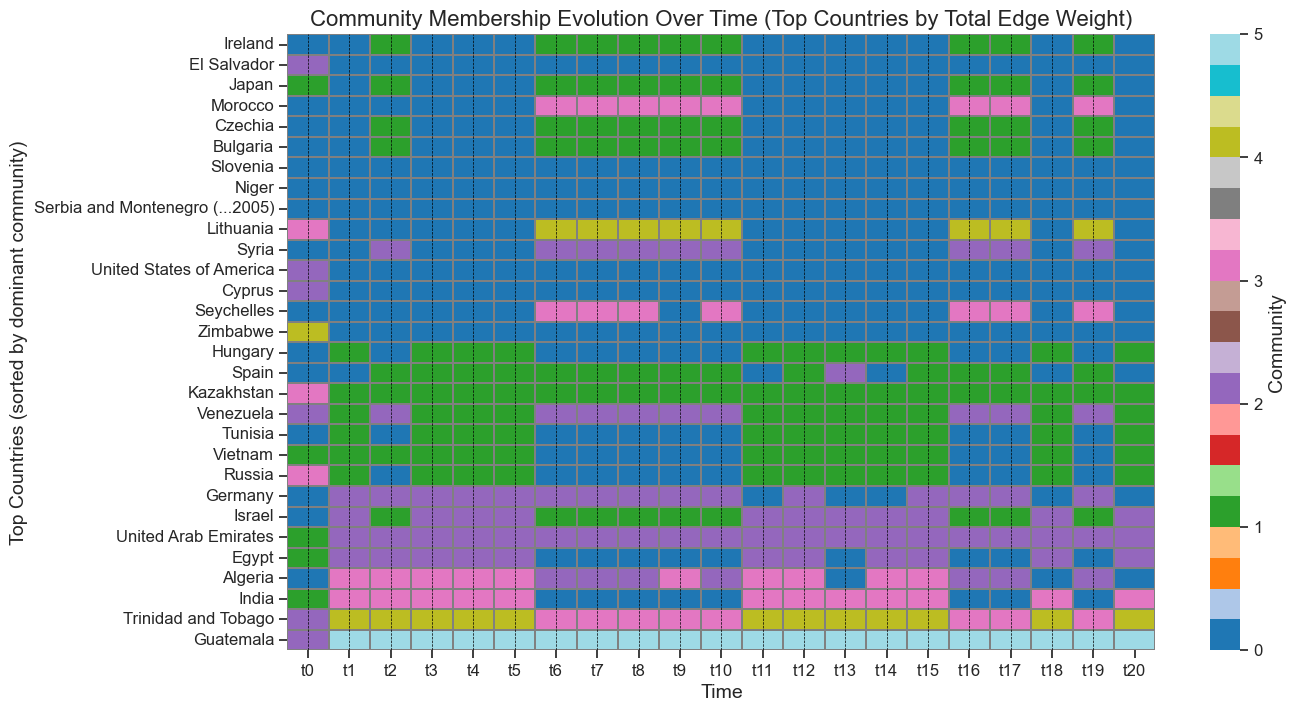

In [87]:
node_to_country = {v.index: v["_nx_name"] for v in snapshots[0].vs}  # Assuming all snapshots share the same node set

node_weights = {}

for t, snapshot in enumerate(snapshots):
    for edge in snapshot.es:
        source = edge.source
        target = edge.target
        weight = edge["weight"] if "weight" in edge.attributes() else 0  # Default weight is 1
        node_weights[source] = node_weights.get(source, 0) + weight
        node_weights[target] = node_weights.get(target, 0) + weight

top_n = 30
most_relevant_nodes = sorted(node_weights, key=node_weights.get, reverse=True)[:top_n]
most_relevant_countries = [node_to_country[node] for node in most_relevant_nodes]
most_relevant_indices = {node: idx for idx, node in enumerate(most_relevant_nodes)}

node_community_matrix_relevant = np.full((len(most_relevant_nodes), len(temporal_membership)), -1)

for t, membership in enumerate(temporal_membership):
    for node, community in enumerate(membership):
        if node in most_relevant_indices:
            node_community_matrix_relevant[most_relevant_indices[node], t] = community

dominant_communities_relevant = np.array([
    np.bincount(row[row >= 0]).argmax() if len(row[row >= 0]) > 0 else -1
    for row in node_community_matrix_relevant
])
sorted_indices_relevant = np.argsort(dominant_communities_relevant)
sorted_matrix_relevant = node_community_matrix_relevant[sorted_indices_relevant]

plt.figure(figsize=(14, 8))
sns.heatmap(
    sorted_matrix_relevant,
    cmap="tab20",
    cbar_kws={"label": "Community"},
    xticklabels=[f"t{t}" for t in range(len(temporal_membership))],
    yticklabels=[most_relevant_countries[i] for i in sorted_indices_relevant],
    linewidths=0.1,
    linecolor="gray",
)

plt.xlabel("Time")
plt.ylabel("Top Countries (sorted by dominant community)")
plt.title("Community Membership Evolution Over Time (Top Countries by Total Edge Weight)")

num_time_slices = len(temporal_membership)
for t in range(num_time_slices - 1):
    plt.axvline(t + 0.5, color="black", linestyle="--", linewidth=0.5)

plt.show()


### Gini Coefficient

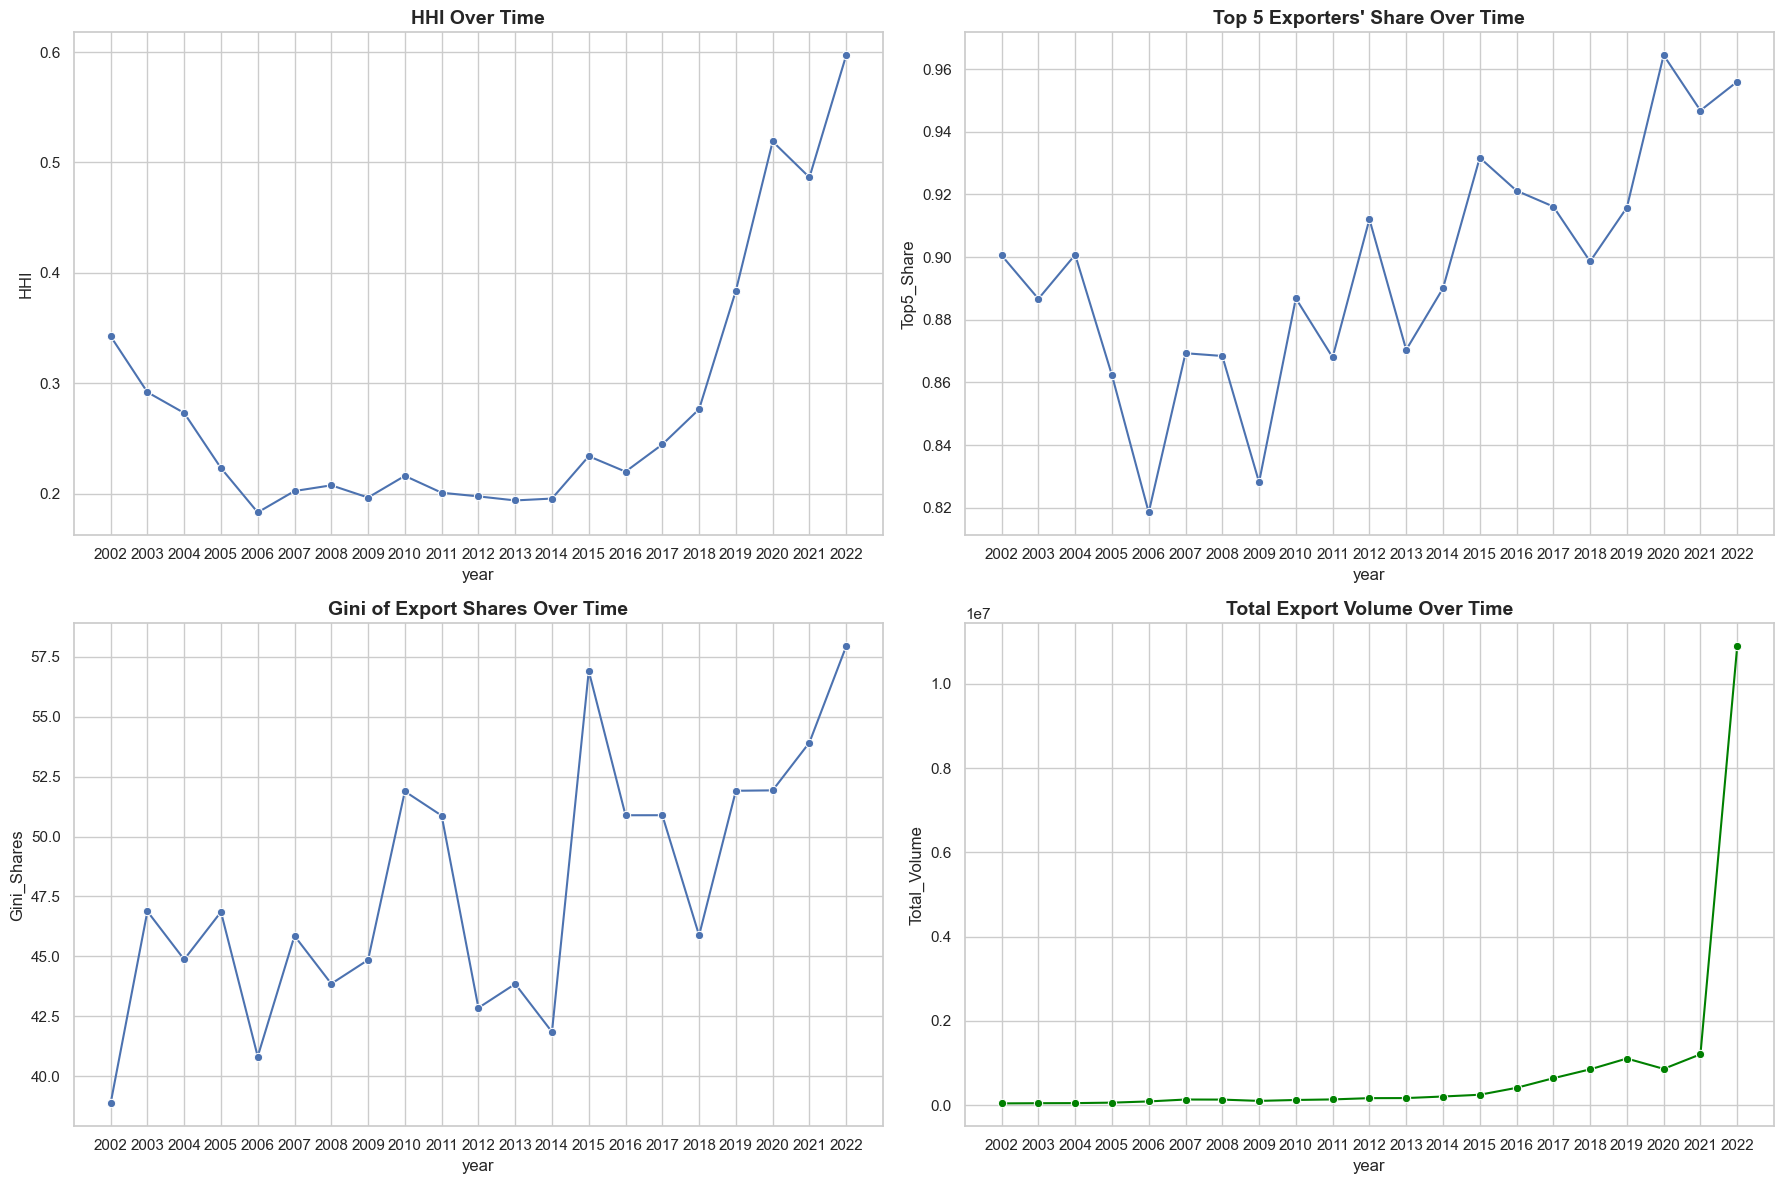

In [88]:
yearly_exports = (
    df.groupby(["t", "export_country"], as_index=False)["v"].sum()
)

years_list = []
hhi_list = []
top5_share_list = []
gini_list = []
shannon_list = []
total_volume_list = []

def gini_coefficient(arr):
    arr = np.array(arr)
    arr = arr[arr > 0]
    arr = np.sort(arr)
    n = len(arr)
    if n == 0:
        return np.nan

    cumulative = np.cumsum(arr)
    sum_arr = cumulative[-1]
    if sum_arr == 0:
        return 0.0

    rel_cumulative = cumulative / sum_arr
    return (n+1 - 2*np.sum(rel_cumulative)/n)

for year, grp in yearly_exports.groupby("t"):
    total_exports = grp["v"].sum()
    shares = grp["v"] / total_exports

    # HHI (Herfindhal Hirschman Index)
    hhi = (shares ** 2).sum()

    # Top 5 Exporter Share
    sorted_shares = np.sort(shares)[::-1]
    top5 = sorted_shares[:5].sum() if len(sorted_shares)>=5 else sorted_shares.sum()

    # Gini Coefficient of Exporter Share
    gini_val = gini_coefficient(shares.values)

    years_list.append(year)
    hhi_list.append(hhi)
    top5_share_list.append(top5)
    gini_list.append(gini_val)
    total_volume_list.append(total_exports)

metrics_df = pd.DataFrame({
    "year": years_list,
    "HHI": hhi_list,
    "Top5_Share": top5_share_list,
    "Gini_Shares": gini_list,
    "Total_Volume": total_volume_list
})

sns.set_theme(style="whitegrid")
fig, axs = plt.subplots(2, 2, figsize=(18, 12))
axs = axs.flatten()

sns.lineplot(data=metrics_df, x="year", y="HHI", marker="o", ax=axs[0])
axs[0].set_title("HHI Over Time", fontsize=14, fontweight='bold')
axs[0].set_xticks(metrics_df["year"].unique().astype(int))

sns.lineplot(data=metrics_df, x="year", y="Top5_Share", marker="o", ax=axs[1])
axs[1].set_title("Top 5 Exporters' Share Over Time", fontsize=14, fontweight='bold')
axs[1].set_xticks(metrics_df["year"].unique().astype(int))

sns.lineplot(data=metrics_df, x="year", y="Gini_Shares", marker="o", ax=axs[2])
axs[2].set_title("Gini of Export Shares Over Time", fontsize=14, fontweight='bold')
axs[2].set_xticks(metrics_df["year"].unique().astype(int))

sns.lineplot(data=metrics_df, x="year", y="Total_Volume", marker="o", ax=axs[3], color='green')
axs[3].set_title("Total Export Volume Over Time", fontsize=14, fontweight='bold')
axs[3].set_xticks(metrics_df["year"].unique().astype(int))

plt.tight_layout()
plt.show()

### Centrality Analysis

In [89]:
crises = [
    (2008, 2009, "World Economic Crisis", '#d3d3d3'),
    (2010, 2011, "European Debt Crisis", '#ffdd44'),
    (2018, 2020, "Trump vs. China Trade War", '#90ee90'),
    (2020, 2022, "COVID Pandemic", '#add8e6'),
    (2020, 2022, "Chip Crisis", '#e6e6fa'),
    (2022, 2023, "Russian Attack on Ukraine", '#ff9999'),
]

In [90]:
def compute_func_over_time(yearly_graphs, func, use_inverse_weight=False, **kwargs):
    centrality_data = []
    for year, graph in yearly_graphs.items():
        if use_inverse_weight and func == nx.degree_centrality:
            # Custom weighted degree centrality using inverse weights
            total_weight = sum(d.get('inverse_weight', 1) for u, v, d in graph.edges(data=True))
            metric_values = {node: sum(data.get('inverse_weight', 1) for _, _, data in graph.edges(node, data=True)) / total_weight
                             for node in graph.nodes()}
        else:
            # Use standard centrality function
            metric_values = func(graph, weight='inverse_weight', **kwargs)

        for node, value in metric_values.items():
            centrality_data.append({'node': node, 'year': year, func.__name__: value})
    return pd.DataFrame(centrality_data)

In [91]:
def plot_func_trends(centrality_df, top_n, func_name):
    top_nodes = (
        centrality_df.groupby('node')[func_name]
        .mean()
        .nlargest(top_n)
        .index
    )
    filtered_df = centrality_df[centrality_df['node'].isin(top_nodes)]
    pivot_df = filtered_df.pivot(index='year', columns='node', values=func_name)

    fig, ax = plt.subplots(figsize=(9, 6))
    pivot_df.plot(ax=ax, marker='o')

    overlapping_colors = ['#d3d3d3', '#ffdd44', '#90ee90', '#add8e6', '#e6e6fa', '#ff9999']

    for i, (start, end, label, color) in enumerate(crises):
        ax.axvspan(start, end, color=overlapping_colors[i], alpha=0.5, zorder=0)

    country_handles, country_labels = ax.get_legend_handles_labels()

    crisis_handles = [
        plt.Line2D([0], [0], color=overlapping_colors[i], lw=8, alpha=0.5, label=label)
        for i, (_, _, label, _) in enumerate(crises)
    ]

    fig.legend(
        handles=country_handles + crisis_handles,
        loc="upper center",
        bbox_to_anchor=(0.5, -0.01),  # Position legend below plot
        ncol=2,
        fontsize="small",
        title="Legends"
    )

    plt.title(f'{func_name} Trends Over Time')
    plt.xlabel('Year')
    plt.xticks(ticks=range(2002, 2024), rotation=45)
    plt.ylabel(func_name.title())
    plt.grid(color="white")
    plt.tight_layout()
    plt.show()


In [92]:
def process_visualization(yearly_graphs, func, top_n, use_inverse_weight=True):
    centrality_df = compute_func_over_time(yearly_graphs, func, use_inverse_weight)
    plot_func_trends(centrality_df, top_n, func.__name__)

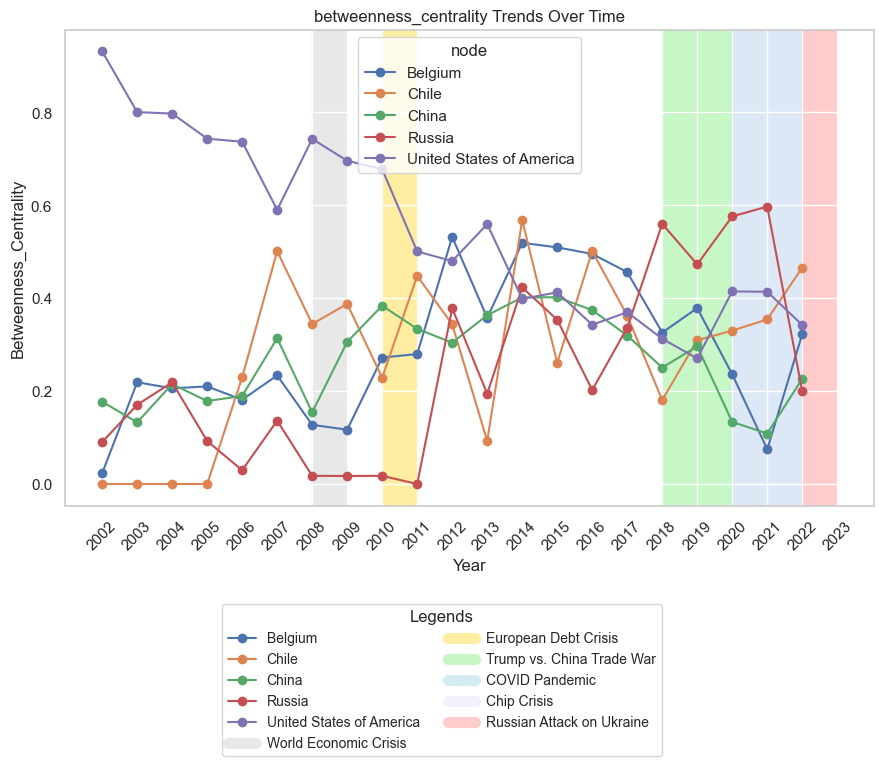

In [93]:
# Betweenness Centrality with Inverse Weight
func = nx.betweenness_centrality
process_visualization(yearly_graphs, func, top_n=5)

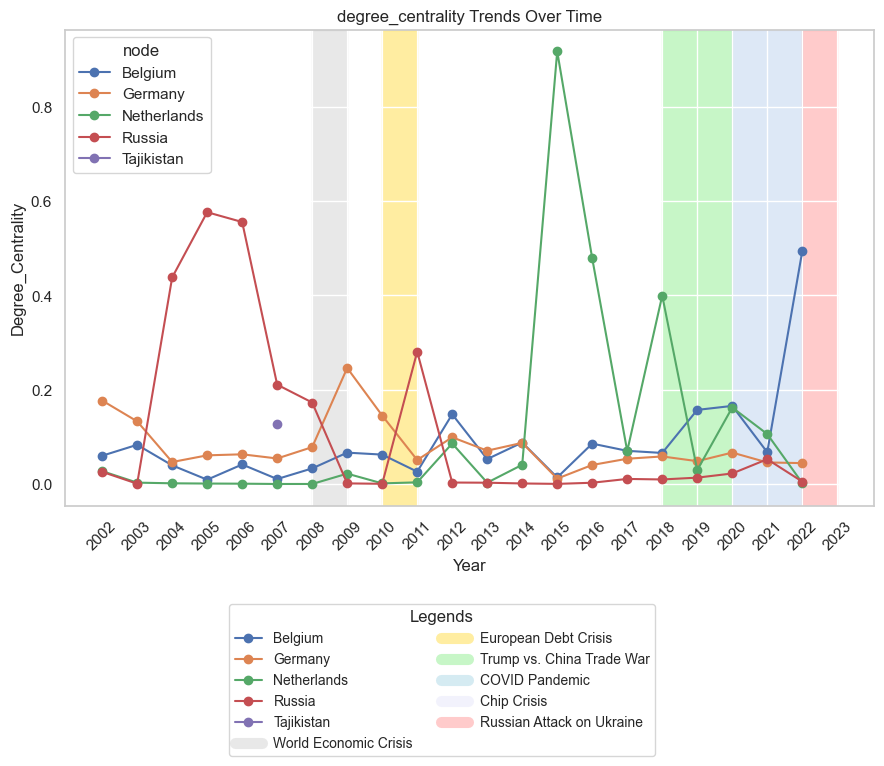

In [94]:
# Degree Centrality with Inverse Weight
func = nx.degree_centrality
process_visualization(yearly_graphs, func, top_n=5, use_inverse_weight=True)

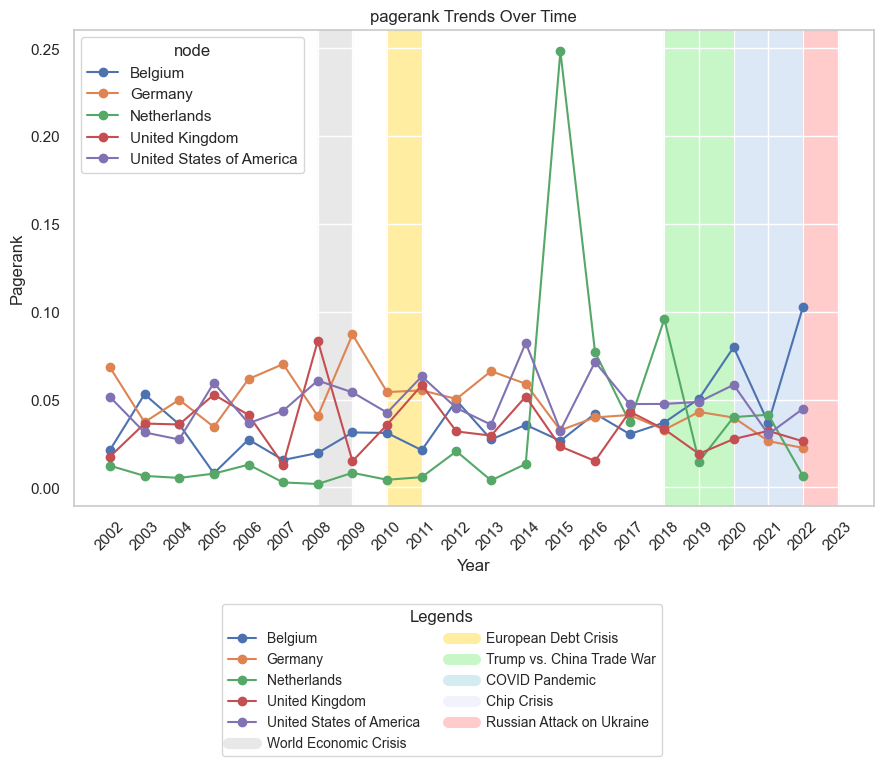

In [95]:
# PageRank with Inverse Weight
func = nx.pagerank
process_visualization(yearly_graphs, func, top_n=5)

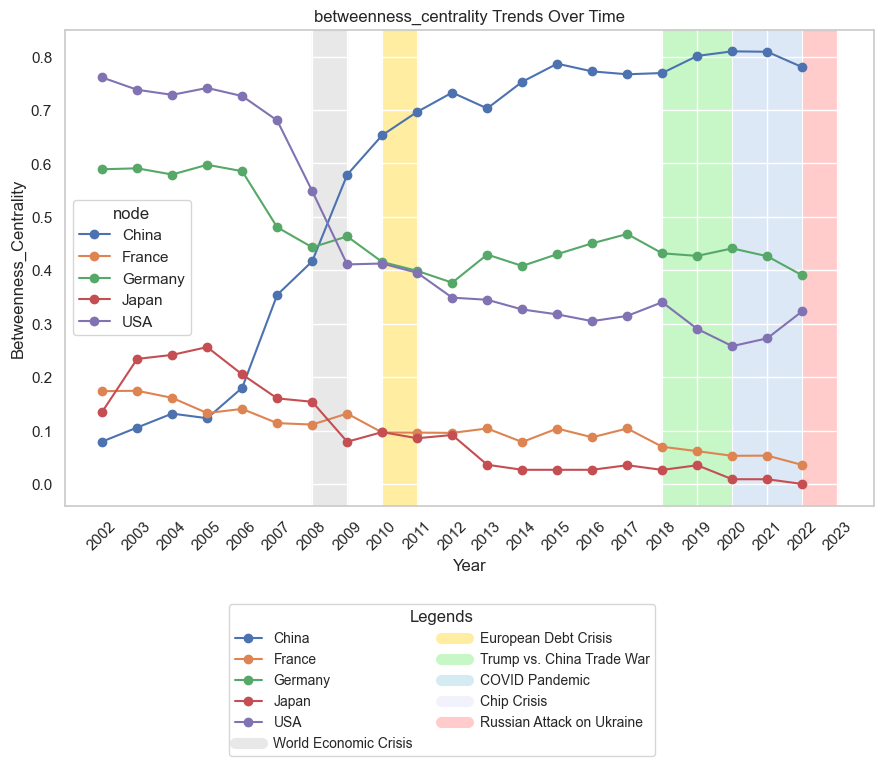

In [96]:
# Betweenness Centrality with Inverse Weight
func = nx.betweenness_centrality
process_visualization(yearly_baseline_graph, func, top_n=5)

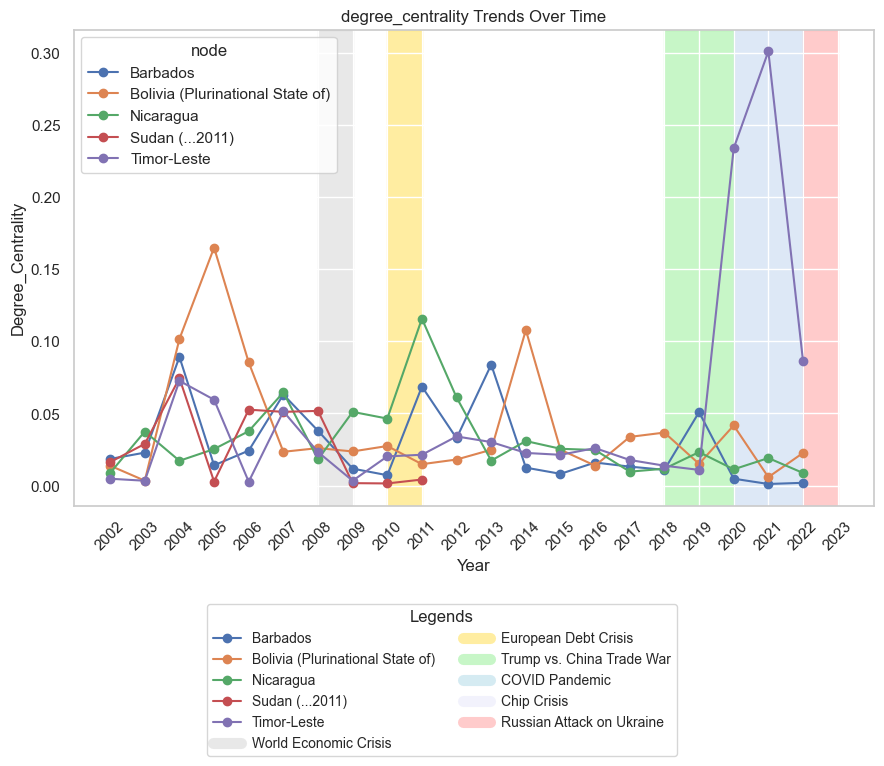

In [97]:
# Degree Centrality with Inverse Weight
func = nx.degree_centrality
process_visualization(yearly_baseline_graph, func, top_n=5, use_inverse_weight=True)

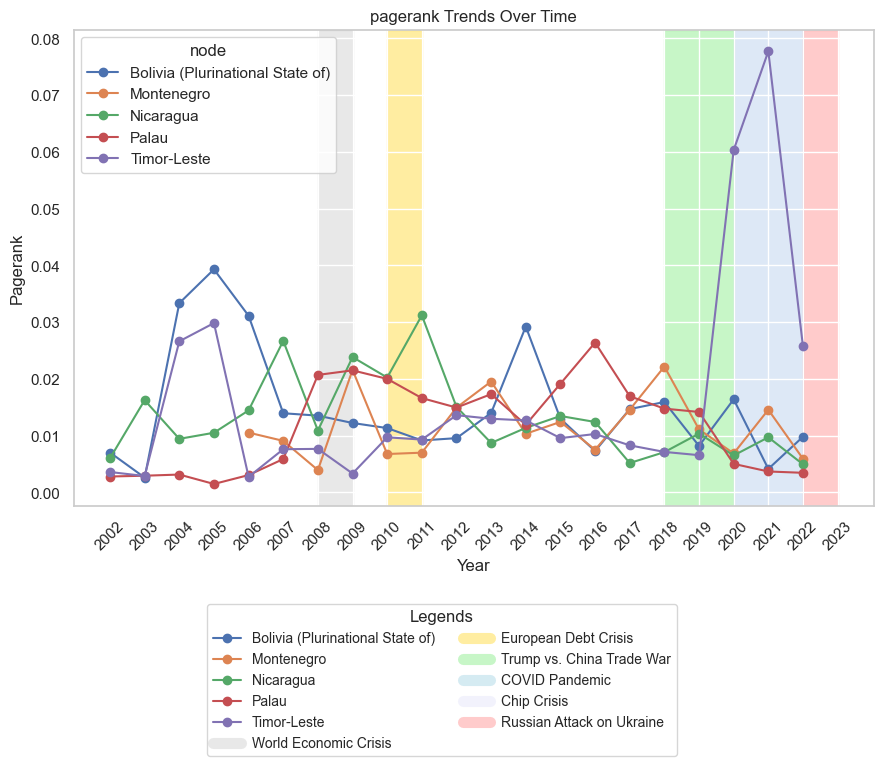

In [98]:
# PageRank with Inverse Weight
func = nx.pagerank
process_visualization(yearly_baseline_graph, func, top_n=5)